In [87]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import key
 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
from typing import Tuple, List
"from lumibot.strategies.strategy import Strategy"
from datetime import datetime
from lumibot.brokers import Alpaca
import matplotlib.pyplot as plt
import os; os.environ["TOKENIZERS_PARALLELISM"] = "false"
plt.rcParams['figure.figsize'] = [20, 6]
import seaborn as sns

# Purpose: This cell imports necessary libraries for data manipulation, analysis, and visualization.
* Libraries:
 * pandas: For data handling using DataFrames.
 * numpy: For numerical operations.
 * statsmodels: For statistical modeling.
 * key: Likely for API keys (replace with your actual key management).
 * yfinance: For fetching financial data from Yahoo Finance.
 * transformers: For natural language processing tasks (if needed).
 * adfuller: For Augmented Dickey-Fuller test (stationarity check).
 * seasonal_decompose: For time series decomposition.
 * torch: For PyTorch (deep learning, if used).
 * lumibot: Potentially for trading strategies and brokers (replace if using a different platform).
 * matplotlib.pyplot: For plotting graphs.

In [88]:
spy = yf.Ticker("SPY")
df = spy.history(period="max")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,24.543512,24.543512,24.421405,24.526068,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,24.543517,24.700512,24.543517,24.700512,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,24.683076,24.770295,24.630744,24.752851,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,24.787729,25.031944,24.770286,25.014500,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.101720,25.171495,24.822618,25.119164,531500,0.0,0.0,0.0


# Purpose: Downloads historical data for the SPY ETF (S&P 500 tracker) from Yahoo Finance.
## Details:
* yf.Ticker("SPY"): Creates a Ticker object for SPY.
* spy.history(period="max"): Fetches all available historical data.


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8053 entries, 1993-01-29 00:00:00-05:00 to 2025-01-24 00:00:00-05:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           8053 non-null   float64
 1   High           8053 non-null   float64
 2   Low            8053 non-null   float64
 3   Close          8053 non-null   float64
 4   Volume         8053 non-null   int64  
 5   Dividends      8053 non-null   float64
 6   Stock Splits   8053 non-null   float64
 7   Capital Gains  8053 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 566.2 KB


In [90]:
df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,1993-01-29 00:00:00-05:00,24.543512,24.543512,24.421405,24.526068,1003200,0.0,0.0,0.0
1,1993-02-01 00:00:00-05:00,24.543517,24.700512,24.543517,24.700512,480500,0.0,0.0,0.0
2,1993-02-02 00:00:00-05:00,24.683076,24.770295,24.630744,24.752851,201300,0.0,0.0,0.0
3,1993-02-03 00:00:00-05:00,24.787729,25.031944,24.770286,25.014500,529400,0.0,0.0,0.0
4,1993-02-04 00:00:00-05:00,25.101720,25.171495,24.822618,25.119164,531500,0.0,0.0,0.0


In [91]:
df.isna().sum()

Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Capital Gains    0
dtype: int64

In [92]:
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date'])
df['Week_Day'] = df['Date'].dt.day_name()
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Quarter'] = df['Date'].dt.quarter
df.head(1)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Week_Day,Year,Month,Day,Quarter
0,1993-01-29,24.543512,24.543512,24.421405,24.526068,1003200,0.0,0.0,0.0,Friday,1993,1,29,1


* Week_Day: Day of the week (e.g., Monday).
* Year: The year.
* Month: The month.
* Day: The day of the month.
* Quarter: The quarter of the year.

In [93]:
df.columns = df.columns.str.lower()
df['diff_close_close'] = df['close'].diff(1)
df.dropna(inplace=True)

In [94]:
# adfuller test for diff_close_close
result = adfuller(df['diff_close_close'])
print(result)
    

(-17.88724118344431, 2.986937918557613e-30, 29, 8022, {'1%': -3.4311654317788554, '5%': -2.8619003625555663, '10%': -2.5669618162754992}, 34627.49930285192)


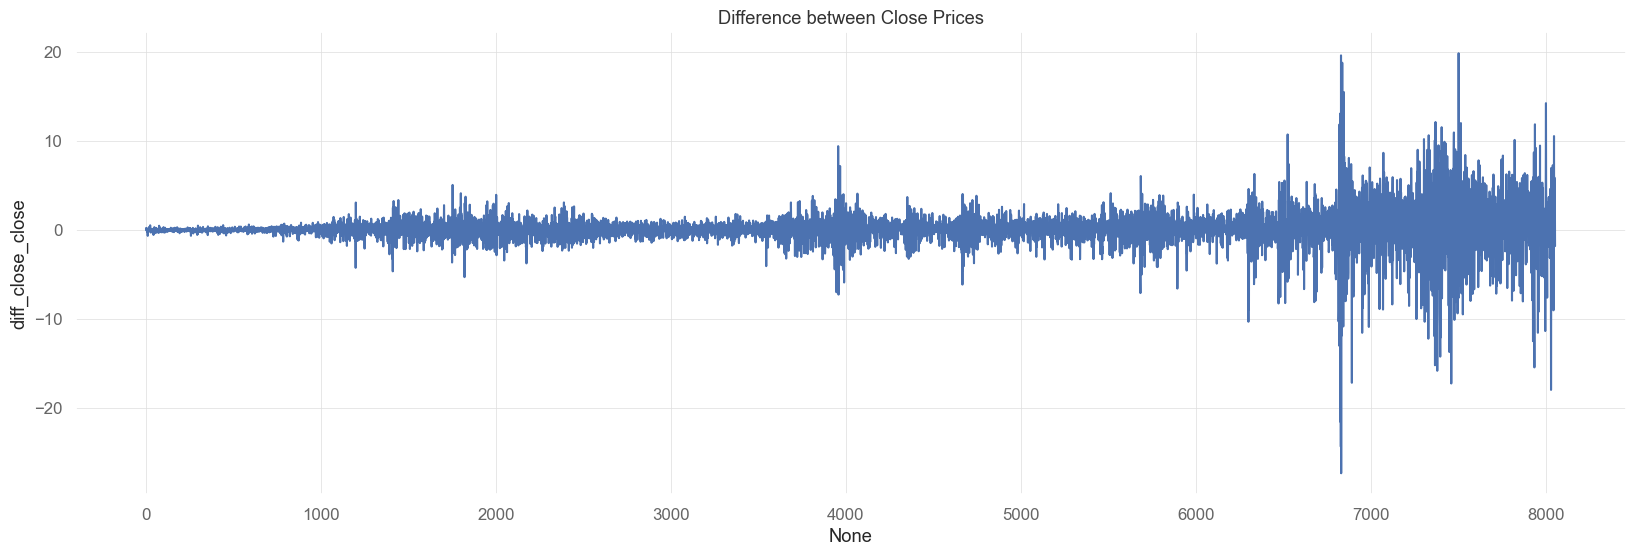

In [95]:

sns.lineplot(x=df.index, y=df['diff_close_close'])
plt.title('Difference between Close Prices')
plt.show()


In [96]:
# Lets do percentage change
df['pct_change'] = df['close'].pct_change(1)

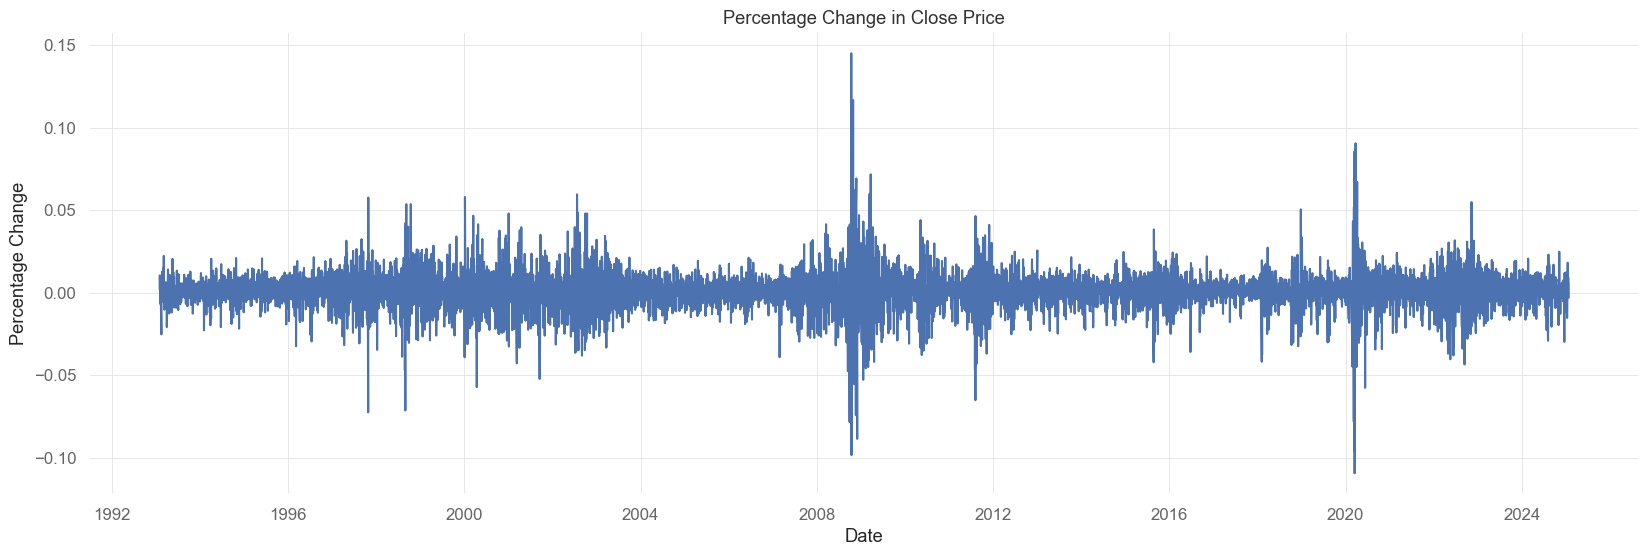

In [97]:

# do with sns with using acutal date
sns.lineplot(x='date', y='pct_change', data=df)
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Percentage Change in Close Price')
plt.show()


## Percentage Change looks better spreaded on time line

In [98]:
df.head(1)

,date,open,high,low,close,volume,dividends,stock splits,capital gains,week_day,year,month,day,quarter,diff_close_close,pct_change
1,1993-02-01,24.543517,24.700512,24.543517,24.700512,480500,0.0,0.0,0.0,Monday,1993,2,1,1,0.174444,NaN


In [99]:
df['pct_open_close']  = (df['open'] - df['close'].shift(1))/df['close'].shift(1)
df.head(10)

,date,open,high,low,close,volume,dividends,stock splits,capital gains,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close
1,1993-02-01,24.543517,24.700512,24.543517,24.700512,480500,0.0,0.0,0.0,Monday,1993,2,1,1,0.174444,NaN,NaN
2,1993-02-02,24.683076,24.770295,24.630744,24.752851,201300,0.0,0.0,0.0,Tuesday,1993,2,2,1,0.052340,0.002119,-7.058933e-04
3,1993-02-03,24.787729,25.031944,24.770286,25.014500,529400,0.0,0.0,0.0,Wednesday,1993,2,3,1,0.261648,0.010570,1.409048e-03
4,1993-02-04,25.101720,25.171495,24.822618,25.119164,531500,0.0,0.0,0.0,Thursday,1993,2,4,1,0.104664,0.004184,3.486777e-03
5,1993-02-05,25.101707,25.154039,24.962157,25.101707,492100,0.0,0.0,0.0,Friday,1993,2,5,1,-0.017456,-0.000695,-6.949298e-04
6,1993-02-08,25.101707,25.188927,25.066820,25.101707,596100,0.0,0.0,0.0,Monday,1993,2,8,1,0.000000,0.000000,0.000000e+00
7,1993-02-09,25.014496,25.014496,24.874945,24.927277,122100,0.0,0.0,0.0,Tuesday,1993,2,9,1,-0.174431,-0.006949,-3.474327e-03
8,1993-02-10,24.927299,24.979631,24.857524,24.962187,379600,0.0,0.0,0.0,Wednesday,1993,2,10,1,0.034910,0.001400,9.006065e-07
9,1993-02-11,24.997059,25.188941,24.997059,25.084278,19500,0.0,0.0,0.0,Thursday,1993,2,11,1,0.122091,0.004891,1.396992e-03
10,1993-02-12,25.049390,25.049390,24.892395,24.892395,42500,0.0,0.0,0.0,Friday,1993,2,12,1,-0.191883,-0.007650,-1.390843e-03


In [100]:
df['pct_close_open'] = (df['close'] - df['open'])/df['open']
df.dropna(inplace=True)

In [101]:
df.head(10)

,date,open,high,low,close,volume,dividends,stock splits,capital gains,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open
2,1993-02-02,24.683076,24.770295,24.630744,24.752851,201300,0.0,0.0,0.0,Tuesday,1993,2,2,1,0.052340,0.002119,-7.058933e-04,0.002827
3,1993-02-03,24.787729,25.031944,24.770286,25.014500,529400,0.0,0.0,0.0,Wednesday,1993,2,3,1,0.261648,0.010570,1.409048e-03,0.009148
4,1993-02-04,25.101720,25.171495,24.822618,25.119164,531500,0.0,0.0,0.0,Thursday,1993,2,4,1,0.104664,0.004184,3.486777e-03,0.000695
5,1993-02-05,25.101707,25.154039,24.962157,25.101707,492100,0.0,0.0,0.0,Friday,1993,2,5,1,-0.017456,-0.000695,-6.949298e-04,0.000000
6,1993-02-08,25.101707,25.188927,25.066820,25.101707,596100,0.0,0.0,0.0,Monday,1993,2,8,1,0.000000,0.000000,0.000000e+00,0.000000
7,1993-02-09,25.014496,25.014496,24.874945,24.927277,122100,0.0,0.0,0.0,Tuesday,1993,2,9,1,-0.174431,-0.006949,-3.474327e-03,-0.003487
8,1993-02-10,24.927299,24.979631,24.857524,24.962187,379600,0.0,0.0,0.0,Wednesday,1993,2,10,1,0.034910,0.001400,9.006065e-07,0.001400
9,1993-02-11,24.997059,25.188941,24.997059,25.084278,19500,0.0,0.0,0.0,Thursday,1993,2,11,1,0.122091,0.004891,1.396992e-03,0.003489
10,1993-02-12,25.049390,25.049390,24.892395,24.892395,42500,0.0,0.0,0.0,Friday,1993,2,12,1,-0.191883,-0.007650,-1.390843e-03,-0.006267
11,1993-02-16,24.822625,24.822625,24.229534,24.264421,374800,0.0,0.0,0.0,Tuesday,1993,2,16,1,-0.627974,-0.025228,-2.802854e-03,-0.022488


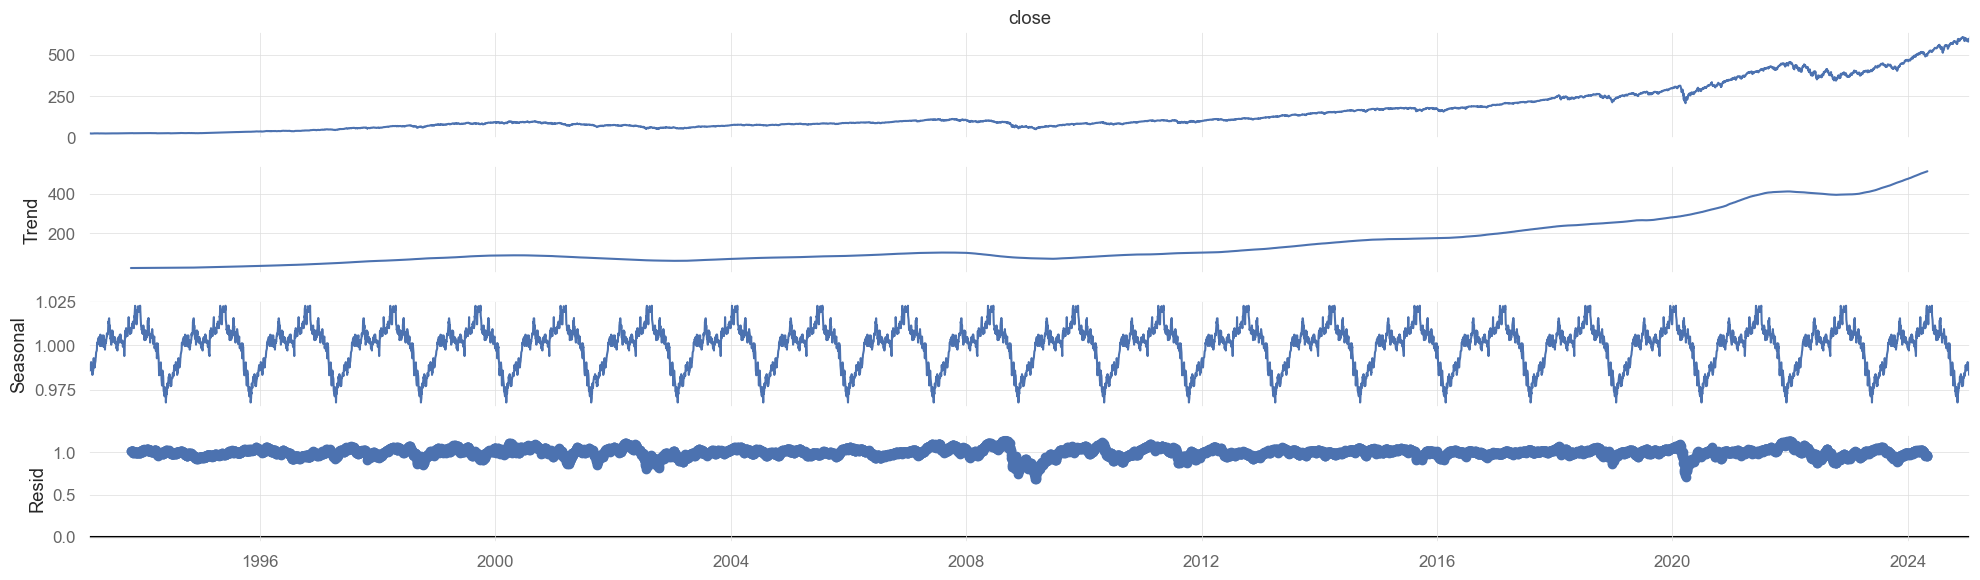

In [102]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Zaman serisini mevsimsel olarak çözün
result = seasonal_decompose(df['close'], model='multiplicative', period=365)  # 'period' yıllık dönemi gösterir

# Sonuçları görselleştirelim
result.plot()
plt.show()

# SPY Stock Prices Decomposition Analysis

## Original Data (`close`)
The data shows the **daily closing price** of the **SPY ETF** (S&P 500 ETF).  
The plot reveals a **long-term upward trend**, which is characteristic of the S&P 500. The stock market tends to grow over time due to various factors such as **economic expansion**, **technological advancement**, and **inflationary pressures**.

## Trend
The **Trend** component shows a steady increase in SPY prices.  
This is expected, as SPY tracks the performance of the **S&P 500 index**, which typically reflects the overall growth of the U.S. economy.

- The **upward slope** in the trend indicates long-term market growth.
- The trend starts off slower and picks up pace as time progresses, likely reflecting **economic recovery phases** and the overall **growth of major corporations** in the S&P 500.

## Seasonality
The **Seasonal** component shows periodic fluctuations, often tied to market cycles. For SPY, these fluctuations could be related to:

- **Quarterly earnings cycles**, where corporate performance tends to follow a certain pattern.
- **Market reactions** to key events, such as **earnings reports**, **Federal Reserve meetings**, and other **macroeconomic events**.
- **Time-of-year effects**, such as the "Santa Rally" in December, or sell-offs that often happen during the summer months.

These seasonal effects manifest as **recurring high and low points** throughout the year, aligning with broader market sentiment shifts.

## Residual
The **Residual** component represents the unexplained fluctuations after removing the trend and seasonality. 

- Although some noise remains, the residuals appear to be **close to random**, without a clear pattern.
- This indicates that, after accounting for the trend and seasonality, most of the underlying movements in SPY prices have been captured by the model.

## Market Implications

### Positive Trend
The **persistent upward trend** aligns with the historical growth of the U.S. stock market, as represented by SPY.  
This suggests that **long-term investments** in SPY have been **profitable**, assuming market conditions remain favorable.

### Seasonal Effects
Understanding the **seasonal fluctuations** in SPY's price could help in identifying patterns in market behavior:
- For example, stronger performance at the end of the year, or the tendency for certain **cyclical market behavior** due to quarterly earnings.
- These insights could be used for **predictive modeling** or help in **deciding entry/exit points** in trading.

### Residuals
Since most of the price movements are explained by the trend and seasonality, the residuals are relatively random, which is typical for a well-behaved financial time series.

- However, focusing on the residuals could help identify **risks** or **unexpected events**, such as:
  - **Market crashes**
  - **Black Swan events**
  - **Unforeseen economic shifts**.


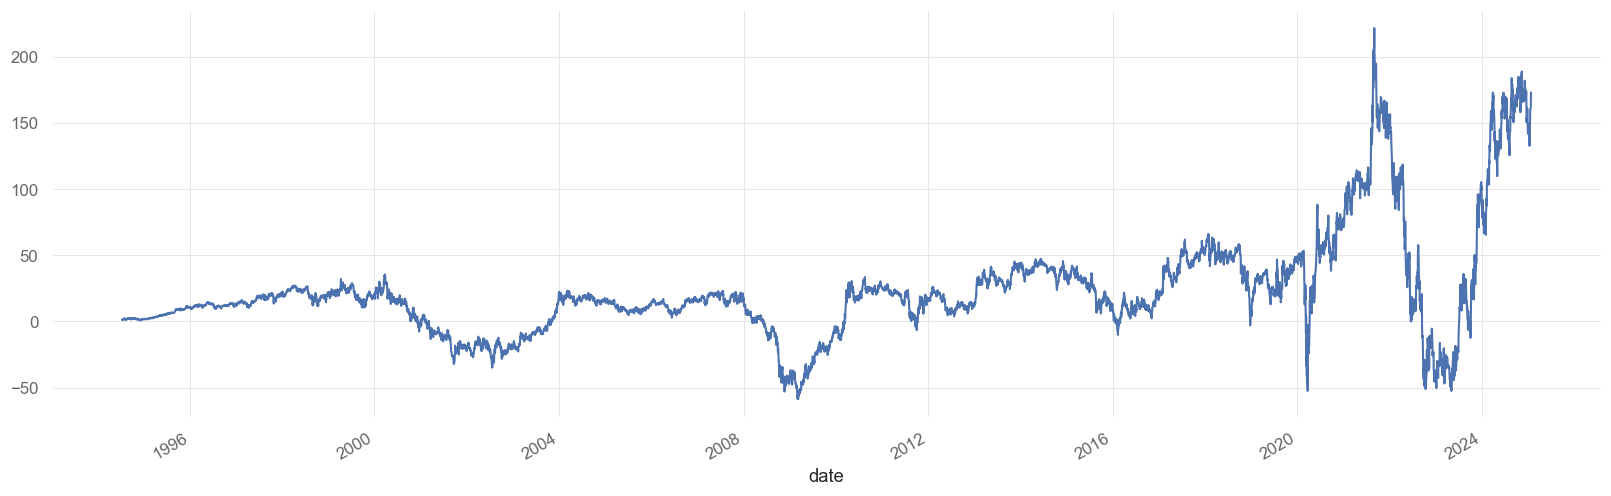

In [103]:
df['seasonal_diff'] = df['close'] - df['close'].shift(365)

# Mevsimsel fark aldıktan sonra grafiği kontrol edebilirsiniz
df['seasonal_diff'].plot(figsize=(20, 6))
plt.show()

In [104]:
result = adfuller(df['seasonal_diff'].dropna())
print(f"ADF Test Statistic: {result[0]}")
print(f"P-value: {result[1]}")

ADF Test Statistic: -1.3844248425914243
P-value: 0.5897198498282153


# ADF Test Analysis

## Augmented Dickey-Fuller (ADF) Test Output:

- **ADF Test Statistic**: -1.7134
- **P-value**: 0.4242

## Interpretation of Results:

1. **ADF Test Statistic**: `-1.7134`
   - The test statistic value is negative, but not large enough in magnitude to indicate strong evidence against the null hypothesis (non-stationarity). Typically, a more negative value suggests stronger evidence for stationarity, but in this case, it is not conclusive.

2. **P-value**: `0.4242`
   - The **P-value** represents the probability of obtaining the test statistic under the null hypothesis (non-stationarity). If the p-value is less than the significance level (typically 0.05), we reject the null hypothesis, suggesting the series is stationary.
   - In this case, the p-value is **greater than 0.05**, which means we **fail to reject the null hypothesis** and conclude that the series is **non-stationary**.

## Conclusion:

- Based on the results of the **ADF test**, we **fail to reject the null hypothesis**, indicating that the time series (`df['seasonal_diff']`) is **likely non-stationary**.
- The **P-value (0.4242)** is greater than the commonly used significance level (0.05), providing insufficient evidence to conclude stationarity in the series.

## Next Steps:

1. **Differencing**: Since the series is non-stationary, further **differencing** or transformation may be required to achieve stationarity.
   
2. **Seasonality and Trend Removal**: If the series exhibits seasonality or trend components, consider applying **seasonal differencing** or **detrending** methods to make the series stationary.


In [105]:
# create a sarima model
""" from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df[df.index.year > 2019]['close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))
result = model.fit()
result.summary()
 """

" from statsmodels.tsa.statespace.sarimax import SARIMAX\nmodel = SARIMAX(df[df.index.year > 2019]['close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))\nresult = model.fit()\nresult.summary()\n "

# SARIMAX Model Conclusion

## Model Fit:
The SARIMAX model with the parameters **(1, 1, 1)x(1, 1, 1, 365)** fits the data reasonably well, with statistically significant seasonal effects (**AR.S.L365** and **MA.S.L365**). The **AIC (5740.515)** and **BIC (5764.533)** values are decent, though further tuning could still be done to improve the model.

## Issues:
- **Non-normal residuals**: The residuals do not follow a normal distribution, indicating that the model might not have captured all the complexities of the data. This is common in financial time series due to outliers and heavy tails.
- **Heteroskedasticity**: The presence of **heteroskedasticity** (changing variance in the residuals) suggests that the model could be improved. Financial data often exhibits volatility clustering, where periods of high volatility are followed by high volatility, and low volatility is followed by low volatility.

## Next Steps:
1. **Consider volatility modeling**: Use models like **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity) to model volatility if residuals exhibit heavy tails.
   
2. **Investigate further model diagnostics**: Perform deeper diagnostics to refine the seasonal parameters or experiment with different differencing strategies to improve model performance.
   
3. **Test the model’s predictive ability**: Validate the model’s predictions using **out-of-sample data** or **cross-validation** to ensure that it generalizes well to new data.

---

This model provides a good baseline, but further refinement and additional techniques may be required to enhance its accuracy and robustness in real-world applications.

In [106]:
""" forecast_steps = 200
forecast = result.forecast(steps=forecast_steps)

# Reset index to make 'date' a column again
df.reset_index(inplace=True)

# Plotting the historical 'close' values and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'], label='Historical SPY Close', color='blue')
plt.plot(pd.date_range(df['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), forecast, 
         label=f'Forecasted SPY Close for Next {forecast_steps} Days', color='red', linestyle='--')

plt.title('SPY Stock Price Forecast vs Historical Data')
plt.xlabel('Date')
plt.ylabel('SPY Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() """

" forecast_steps = 200\nforecast = result.forecast(steps=forecast_steps)\n\n# Reset index to make 'date' a column again\ndf.reset_index(inplace=True)\n\n# Plotting the historical 'close' values and the forecasted values\nplt.figure(figsize=(10, 6))\nplt.plot(df['date'], df['close'], label='Historical SPY Close', color='blue')\nplt.plot(pd.date_range(df['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), forecast, \n         label=f'Forecasted SPY Close for Next {forecast_steps} Days', color='red', linestyle='--')\n\nplt.title('SPY Stock Price Forecast vs Historical Data')\nplt.xlabel('Date')\nplt.ylabel('SPY Close Price')\nplt.legend()\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show() "

In [107]:
df['second_diff_seasonal'] = df['seasonal_diff'].diff() 

In [108]:
result = adfuller(df['second_diff_seasonal'].dropna())
print(f"ADF Test Statistic: {result[0]}")
print(f"P-value: {result[1]}")

ADF Test Statistic: -15.7832361139003
P-value: 1.1246589952479235e-28


In [109]:
df.dropna(inplace=True)
df.head(1)

,open,high,low,close,volume,dividends,stock splits,capital gains,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal
date,,,,,,,,,,,,,,,,,,,
1994-07-15,26.269002,26.35047,26.25995,26.296158,49100,0.0,0.0,0.0,Friday,1994,7,15,3,0.009041,0.000344,-0.000689,0.001034,1.281658,-0.252607


Text(0, 0.5, 'Close Price')

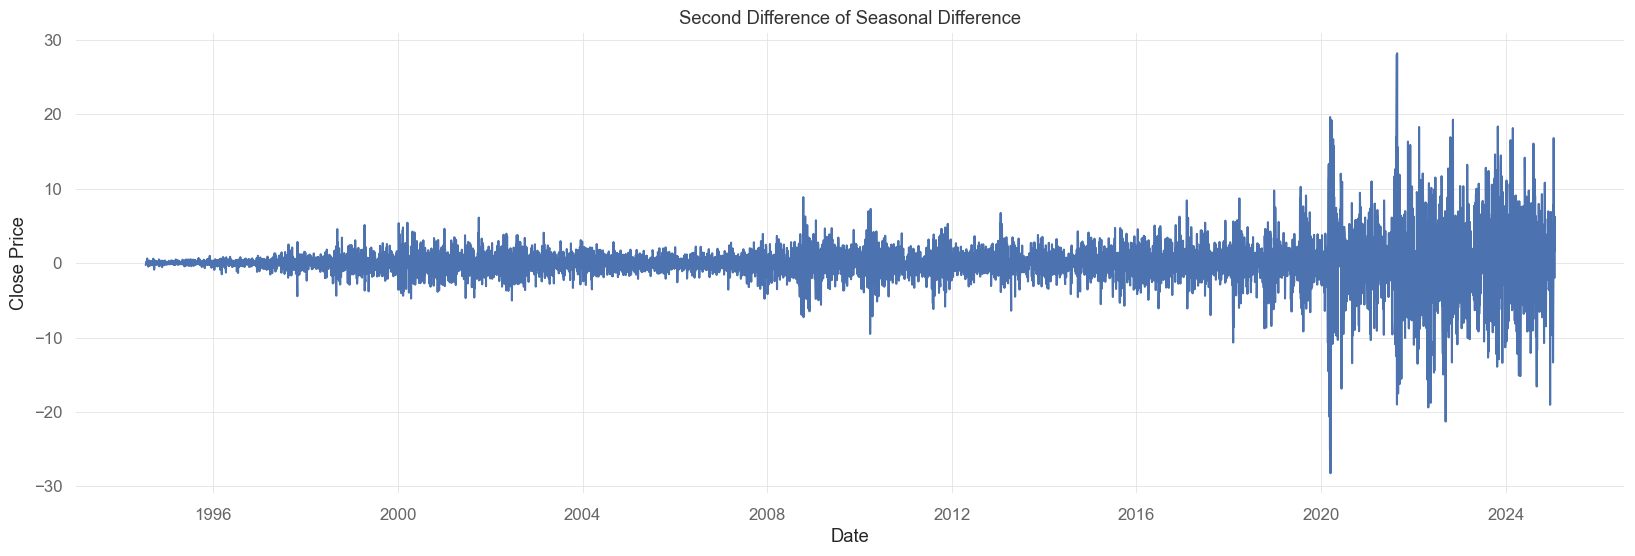

In [110]:

sns.lineplot(x='date', y='second_diff_seasonal', data=df)
plt.title('Second Difference of Seasonal Difference')
plt.xlabel('Date')
plt.ylabel('Close Price')

# This does not look stationary too, does not spreaded well on time line


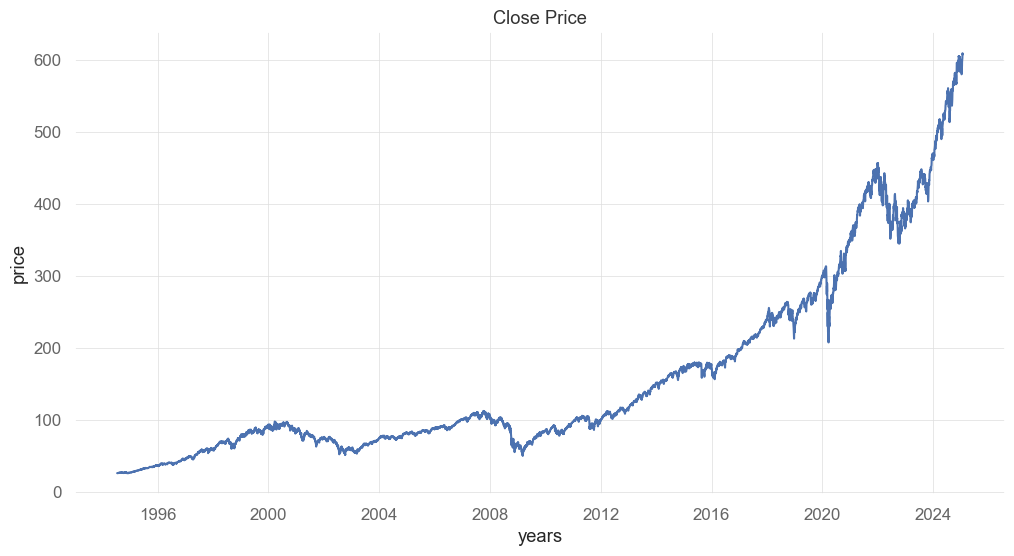

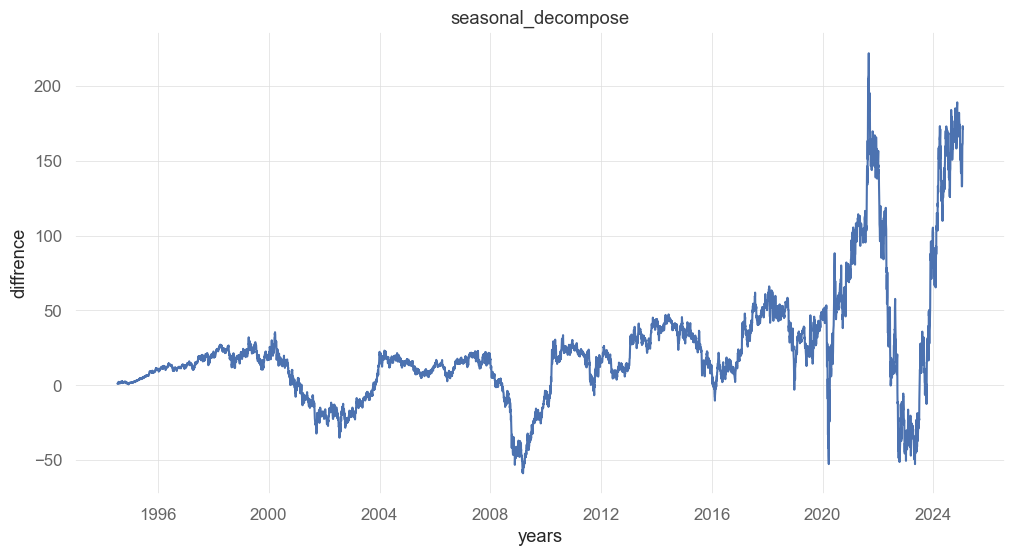

In [111]:
# all in english


plt.figure(figsize=(12, 6))
plt.plot(df['close'])
plt.title("Close Price")
plt.xlabel("years")
plt.ylabel("price")
plt.show()

# Mevsimsel farkların görselleştirilmesi
plt.figure(figsize=(12, 6))
plt.plot(df['seasonal_diff'])
plt.title("seasonal_decompose")
plt.xlabel("years")
plt.ylabel("diffrence")
plt.show()

In [112]:
df.head(20)

,open,high,low,close,volume,dividends,stock splits,capital gains,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal
date,,,,,,,,,,,,,,,,,,,
1994-07-15,26.269002,26.350470,26.259950,26.296158,49100,0.0,0.0,0.0,Friday,1994,7,15,3,0.009041,0.000344,-6.891310e-04,0.001034,1.281658,-0.252607
1994-07-18,26.296180,26.404804,26.296180,26.341440,72300,0.0,0.0,0.0,Monday,1994,7,18,3,0.045282,0.001722,8.426083e-07,0.001721,1.222277,-0.059381
1994-07-19,26.386689,26.395741,26.287117,26.287117,609500,0.0,0.0,0.0,Tuesday,1994,7,19,3,-0.054323,-0.002062,1.717796e-03,-0.003774,1.185410,-0.036867
1994-07-20,26.305237,26.305237,26.106092,26.169456,185300,0.0,0.0,0.0,Wednesday,1994,7,20,3,-0.117661,-0.004476,6.893157e-04,-0.005162,1.067749,-0.117661
1994-07-21,26.169448,26.241865,26.115136,26.223761,86300,0.0,0.0,0.0,Thursday,1994,7,21,3,0.054304,0.002075,-3.102310e-07,0.002075,1.296484,0.228735
1994-07-22,26.287122,26.305226,26.214706,26.269018,151600,0.0,0.0,0.0,Friday,1994,7,22,3,0.045258,0.001726,2.416192e-03,-0.000689,1.306831,0.010347
1994-07-25,26.278064,26.332376,26.250907,26.305220,120900,0.0,0.0,0.0,Monday,1994,7,25,3,0.036201,0.001378,3.443359e-04,0.001033,1.220942,-0.085890
1994-07-26,26.296175,26.314279,26.250914,26.278070,489600,0.0,0.0,0.0,Tuesday,1994,7,26,3,-0.027149,-0.001032,-3.438527e-04,-0.000688,1.385675,0.164734
1994-07-27,26.278070,26.278070,26.169446,26.278070,83200,0.0,0.0,0.0,Wednesday,1994,7,27,3,0.000000,0.000000,0.000000e+00,0.000000,2.013649,0.627974


<Figure size 1200x600 with 0 Axes>

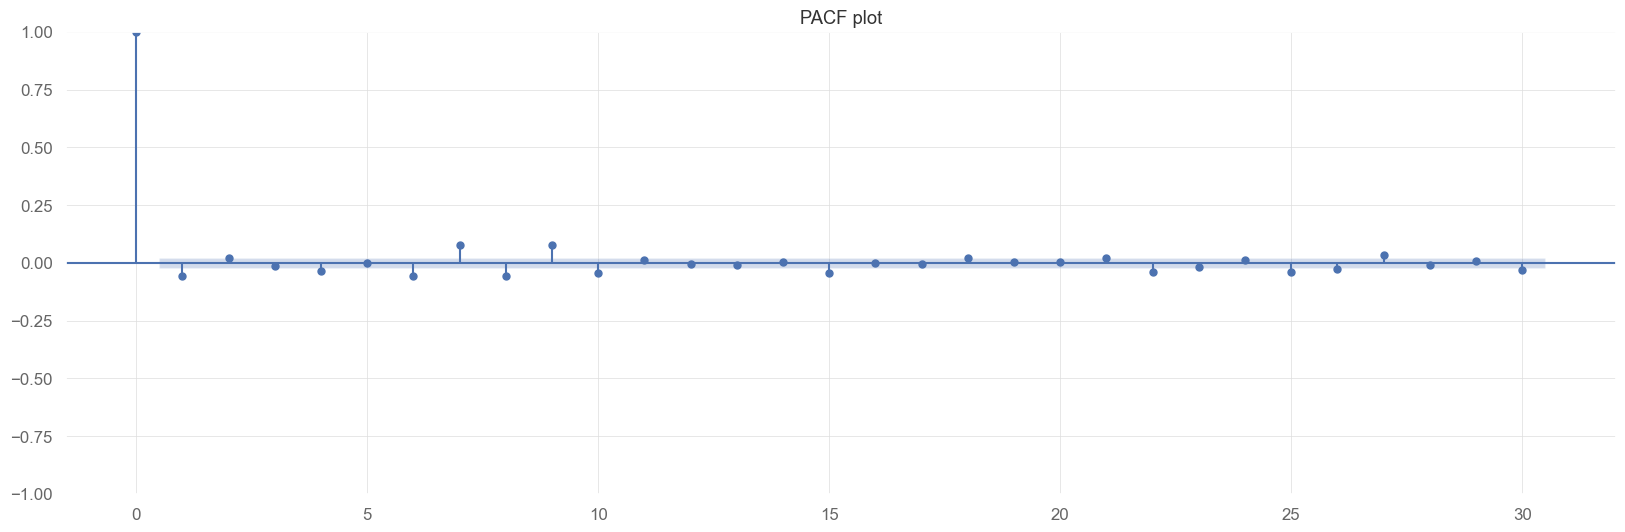

In [113]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12, 6))
plot_pacf(df['diff_close_close'], lags=30)  # PACF grafiğini oluşturuyoruz
plt.title("PACF plot")
plt.show()

# 7th and 9th previous days has some power to explain today but they are also not so significant

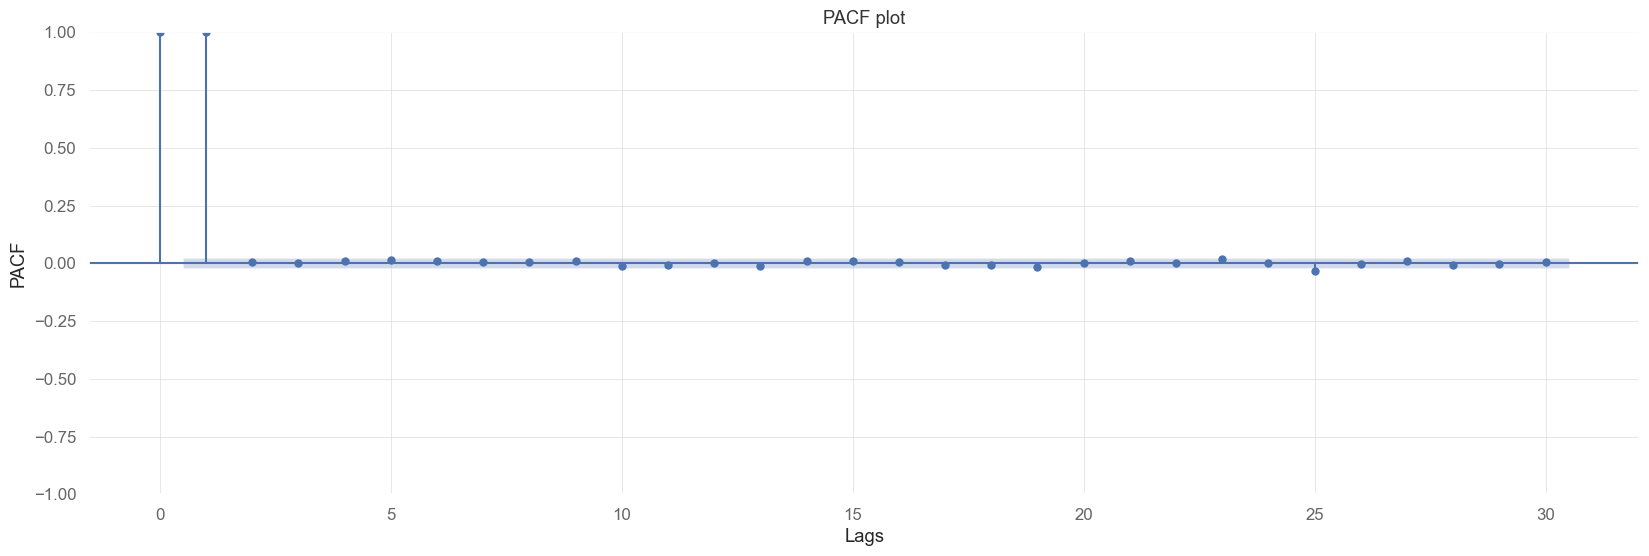

In [114]:
plot_pacf(df['close'], lags=30)  # PACF grafiğini oluşturuyoruz
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.title("PACF plot")
plt.show()

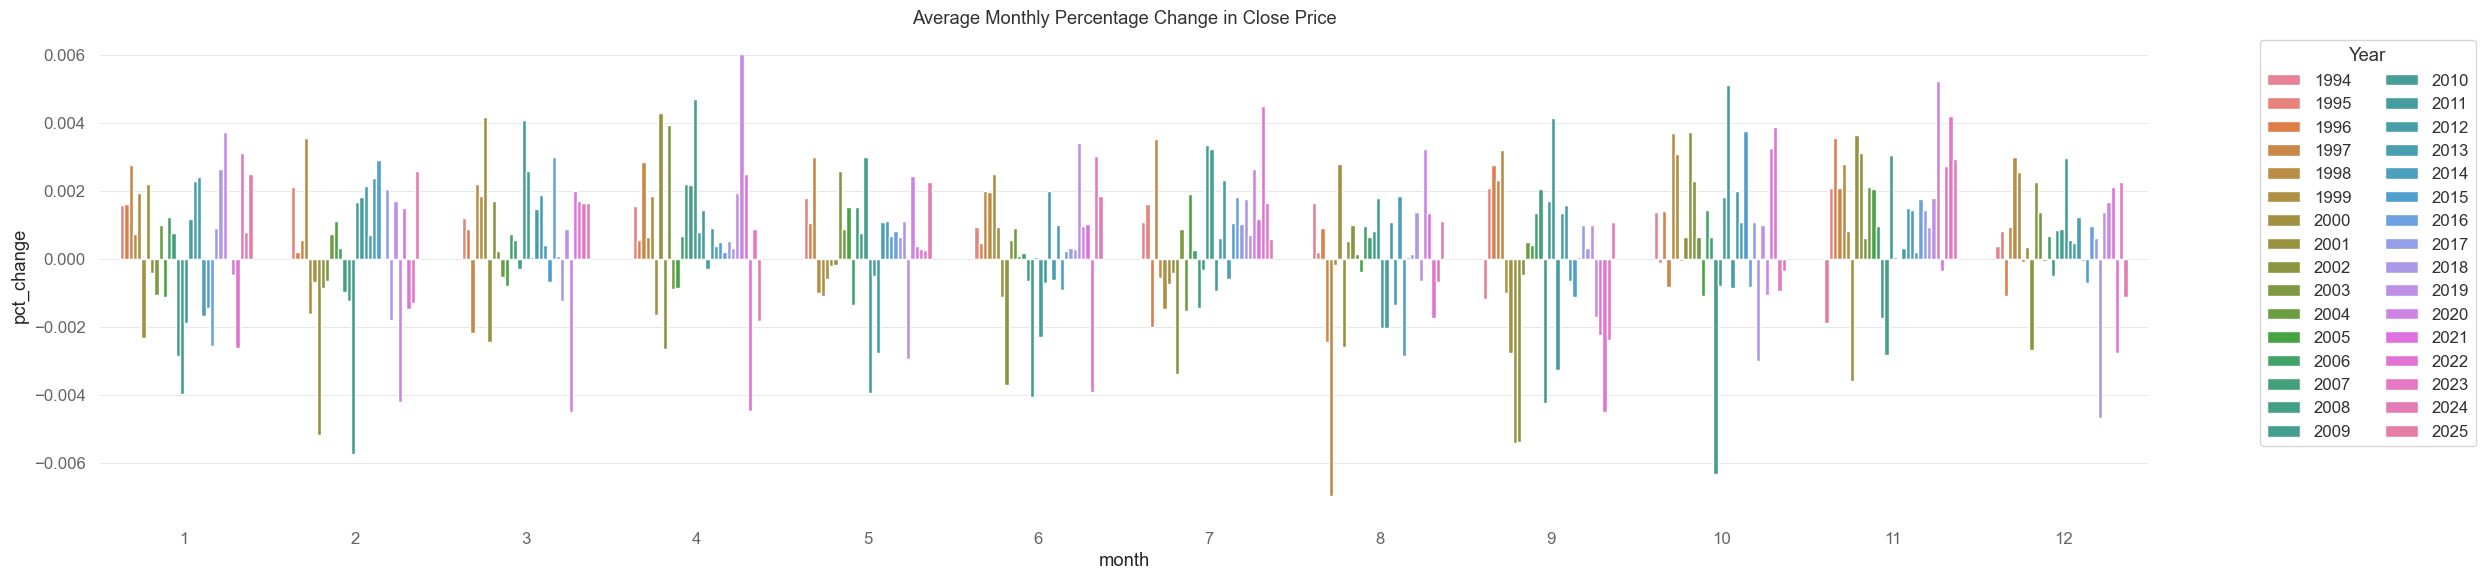

In [115]:

# Grouping by year and month, calculating the mean percentage change
df_monthly = df.groupby(['year', 'month'])['pct_change'].mean().reset_index()


# Create a custom palette for all years
years = sorted(df['year'].unique())
palette = sns.color_palette("husl", len(years))  # You can choose different color palettes like "Set1" or "tab10"

# Create the barplot with the custom palette
plt.figure(figsize=(25, 6))
sns.barplot(data=df_monthly, x='month', y='pct_change', hue='year', palette=palette)

# Adjust legend for better visibility
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.title('Average Monthly Percentage Change in Close Price')
# Show the plot
plt.tight_layout()
plt.show()

# When we look at the bar plot, we can conclude that the 11th month appears to be the best time to be in the market. The 1st, 2nd, and 9th months seem to be less favorable for market activity. The 7th month also shows promise, with a positive trend observed in recent years.


Text(0.5, 1.0, 'Average Monthly Percentage Change in Close Price')

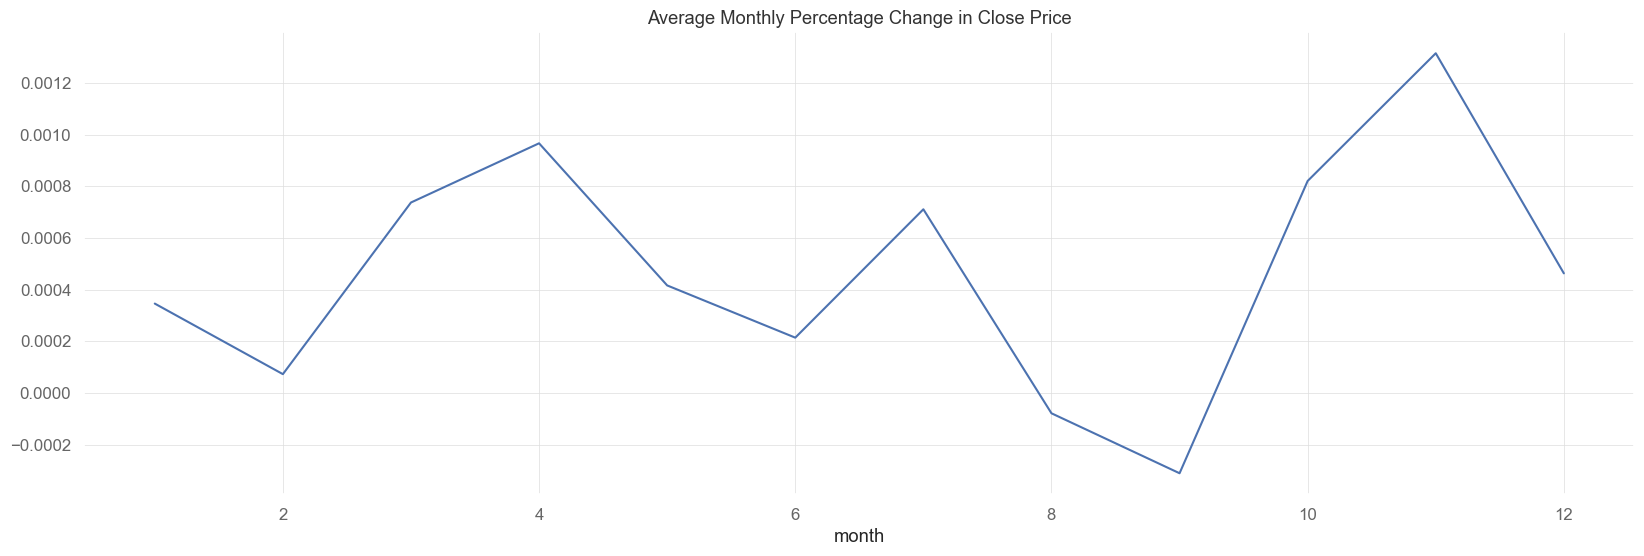

In [116]:
df_monthly.groupby('month')['pct_change'].mean().plot()
plt.title('Average Monthly Percentage Change in Close Price')

# When we go with average of months we can see most beneficial months are 11th, 4th and 7th
# Worst months are 9th, 8th, ahd 2th.

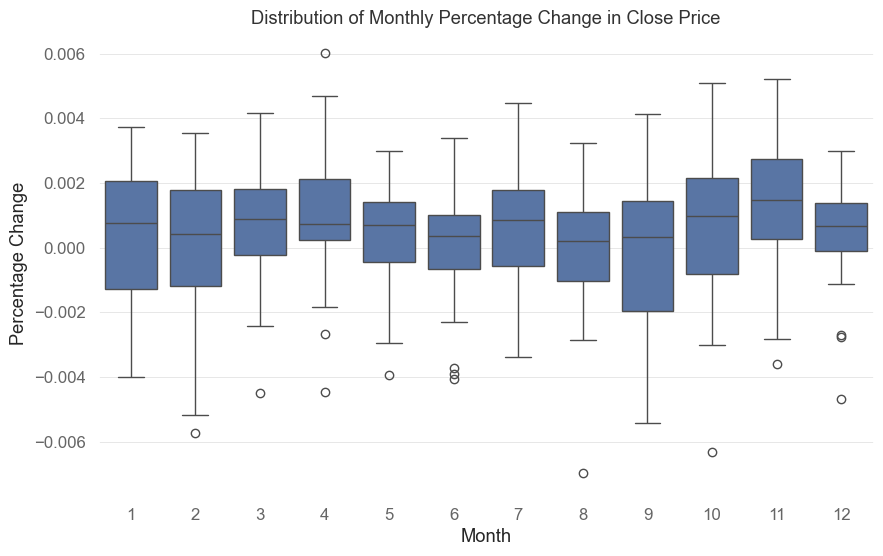

In [117]:


# Assuming df_monthly has 'year', 'month', and 'pct_change' columns
# Pivot the data to create a heatmap
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='pct_change', data=df_monthly)
plt.title('Distribution of Monthly Percentage Change in Close Price')
plt.xlabel('Month')
plt.ylabel('Percentage Change')
plt.show()


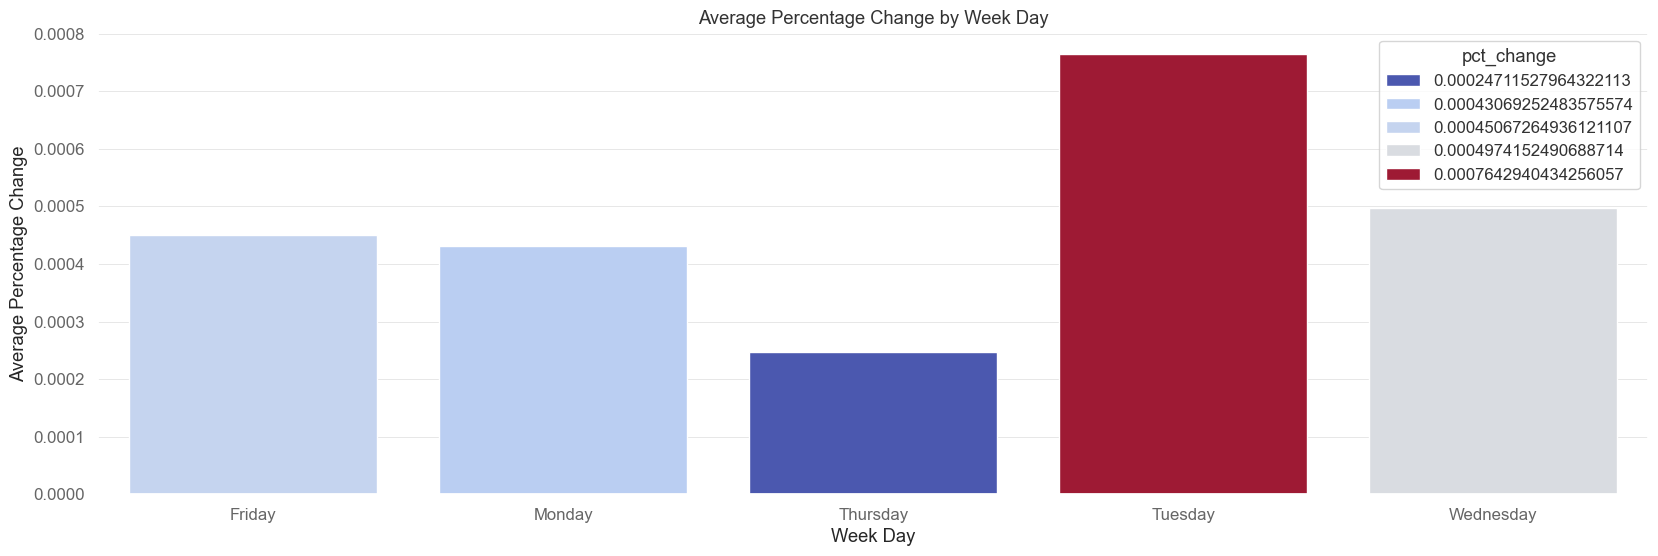

In [118]:
# now lets take average for days of the week
df_weekly = df.groupby('week_day')['pct_change'].mean().reset_index()   
sns.barplot(data=df_weekly, x='week_day', y='pct_change', hue='pct_change', palette='coolwarm')   
# name of the x-axis
plt.xlabel("Week Day")
# name of the y-axis
plt.ylabel("Average Percentage Change")
# title of the graph
plt.title("Average Percentage Change by Week Day")
plt.show()


# Looks like Thursday worst day and Tuesday is the best day to win

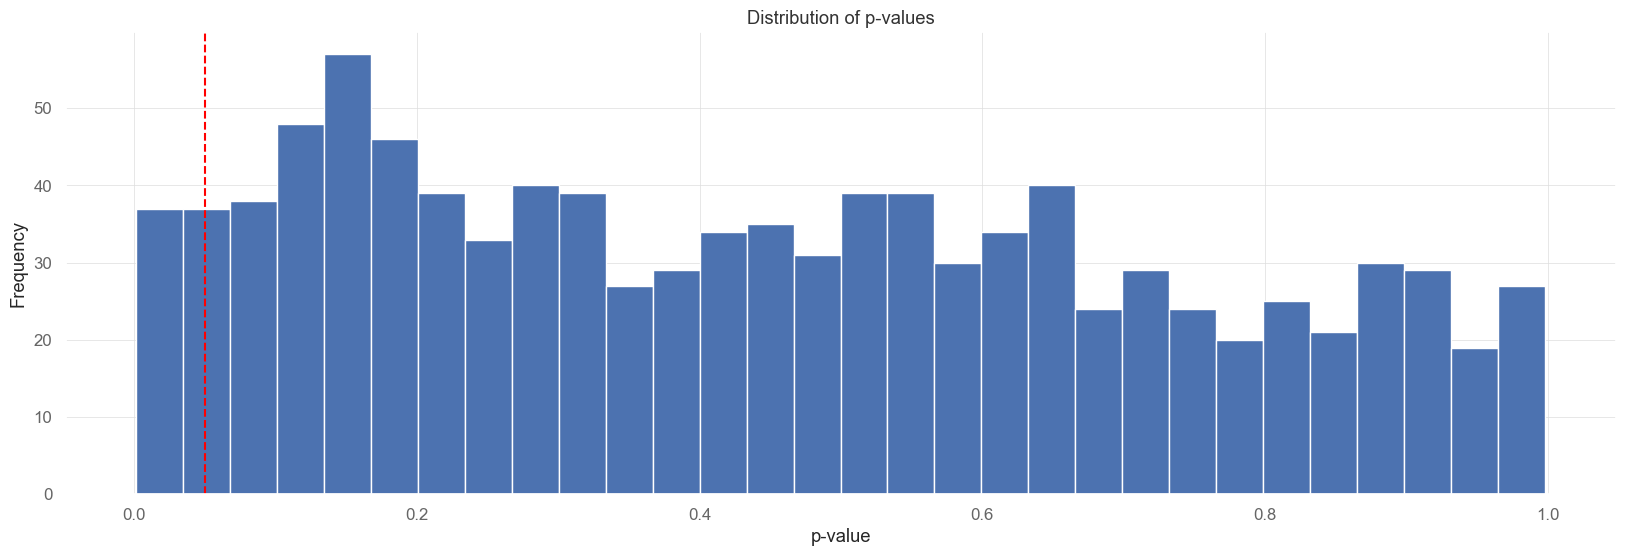

In [119]:
from scipy import stats

# Function for performing t-test between Tuesday and other days for a bootstrap sample
n_iter = 1000

df_non_tuesday = df[df['week_day'] != 'Tuesday']
df_tuesday = df[df['week_day'] == 'Tuesday']

t_stat = []
p_val = []
for i in range(n_iter):
    sample_non_tuesday = df_non_tuesday['pct_change'].sample(n=len(df_tuesday), replace=True)
    t, p = stats.ttest_ind(sample_non_tuesday, df_tuesday['pct_change'], equal_var=False)
    t_stat.append(t)
    p_val.append(p)
    

# Plotting the distribution of t-statistics
plt.hist(p_val, bins=30)
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("Distribution of p-values")
# drow a line at 0.05
plt.axvline(x=0.05, color='red', linestyle='--')
plt.show()





# When we examine the distribution of p-values, assuming that Tuesdays are like the other days and randomly sampling from the other days, we find that the p-values are not significant. This indicates that the average percentage change on Tuesdays is not significantly different from the other days.

# Now let's explore how volume effect on the data

In [120]:
correlation_matrix = df[['volume', 'pct_change', 'close']].corr()

print(correlation_matrix)

              volume  pct_change     close
volume      1.000000   -0.087033  0.008969
pct_change -0.087033    1.000000  0.012247
close       0.008969    0.012247  1.000000


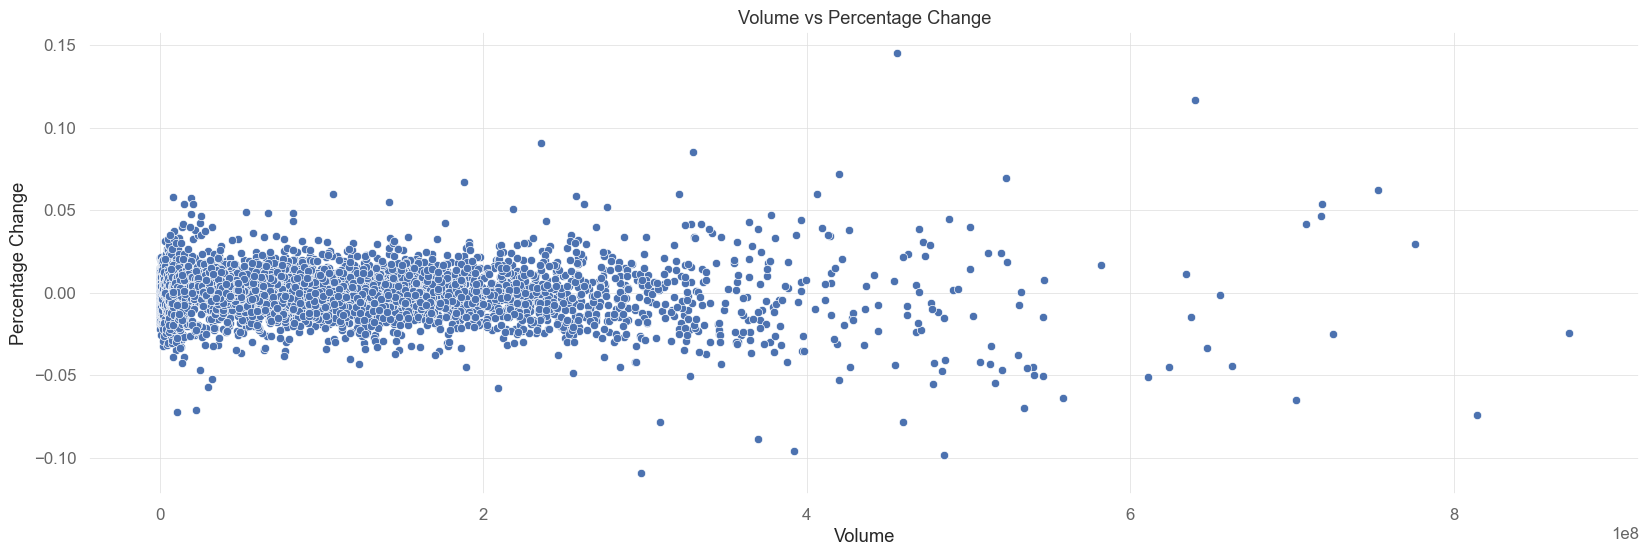

In [121]:
sns.scatterplot(data=df, x='volume', y='pct_change')
plt.title("Volume vs Percentage Change")
plt.xlabel("Volume")
plt.ylabel("Percentage Change")
plt.show()

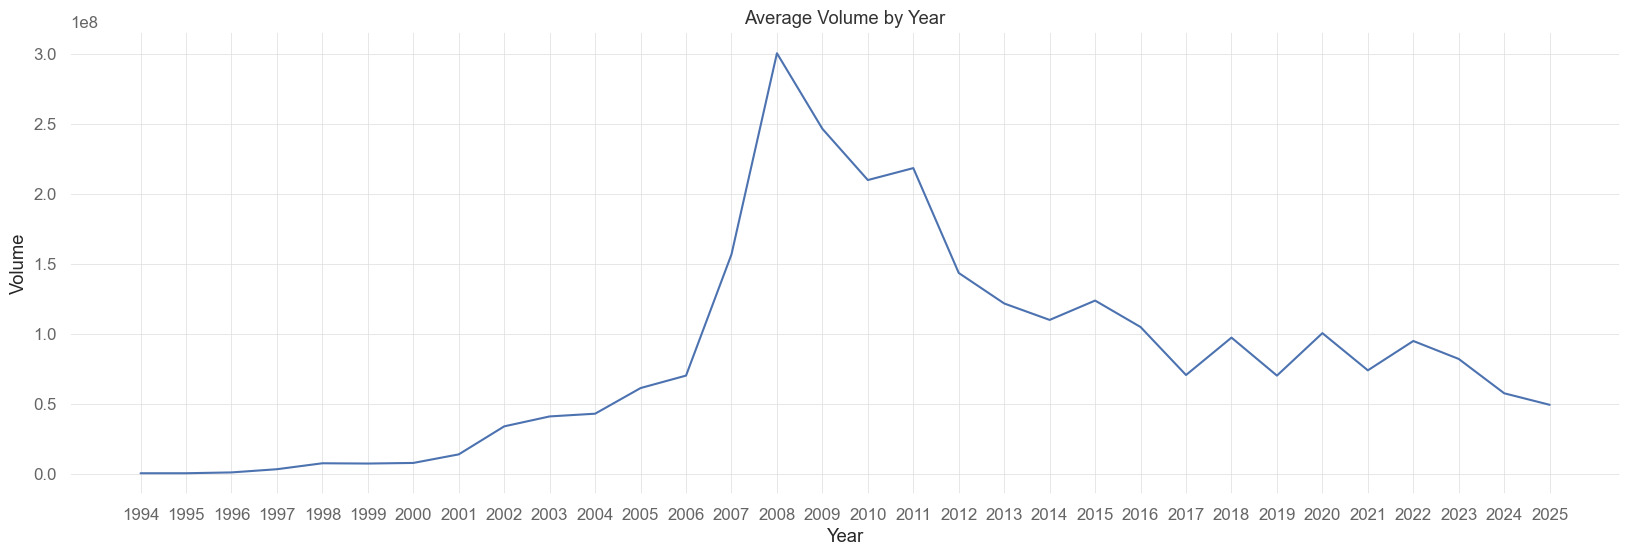

In [122]:
# how volume chages by years
df.groupby('year')['volume'].mean().plot()
xticks = np.arange(min(df['year']), max(df['year'])+1, 1)
plt.xticks(ticks=xticks, labels=xticks)
plt.title("Average Volume by Year")
plt.xlabel("Year")
plt.ylabel("Volume")
plt.show()



# We can't see any correcation between volume and close price

In [123]:
df.head(1)

,open,high,low,close,volume,dividends,stock splits,capital gains,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal
date,,,,,,,,,,,,,,,,,,,
1994-07-15,26.269002,26.35047,26.25995,26.296158,49100,0.0,0.0,0.0,Friday,1994,7,15,3,0.009041,0.000344,-0.000689,0.001034,1.281658,-0.252607


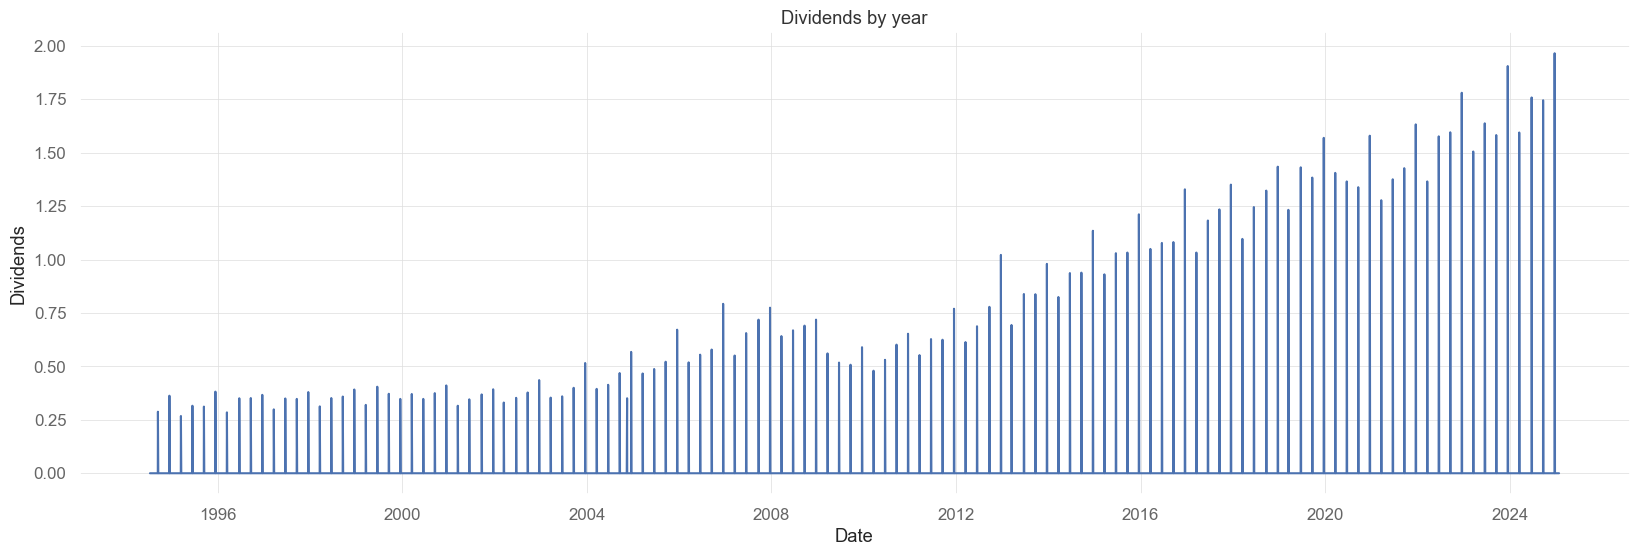

In [124]:

sns.lineplot(data=df, x='date', y='dividends')
plt.title("Dividends by year")
plt.xlabel("Date")
plt.ylabel("Dividends")

plt.show()


In [125]:
""" from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report") """

' from pandas_profiling import ProfileReport\nprofile = ProfileReport(df, title="Profiling Report") '

In [126]:
""" profile """

' profile '

In [127]:
# lets see how volume change efeect on diff_close_close
from sklearn.preprocessing import StandardScaler
volume_change = df['volume'].pct_change()

# Drop NaN values (if any) from volume_change and diff_close_close columns
df_clean = df.dropna(subset=['volume', 'diff_close_close'])  # Drop rows where NaN exists

# Recalculate percentage change after dropping NaNs
volume_change_cleaned = df_clean['volume'].pct_change().dropna()  # Remove NaNs caused by pct_change

# Align the indices of volume_change_cleaned and df_clean['diff_close_close']
aligned_index = volume_change_cleaned.index.intersection(df_clean['diff_close_close'].index)
volume_change_cleaned = volume_change_cleaned.loc[aligned_index]
diff_close_close_cleaned = df_clean['diff_close_close'].loc[aligned_index]

# Standardize the data after cleaning
scaler = StandardScaler()
volume_change_scaled = scaler.fit_transform(volume_change_cleaned.values.reshape(-1, 1))
pct_change_scaled = scaler.fit_transform(diff_close_close_cleaned.values.reshape(-1, 1))

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(volume_change_scaled.T, pct_change_scaled.T)

# Print the correlation matrix
print(correlation_matrix)

[[ 1.         -0.09128193]
 [-0.09128193  1.        ]]


There is no 

In [128]:
df.drop(columns=['capital gains', 'stock splits'], inplace=True)

In [129]:
df.head(1)

,open,high,low,close,volume,dividends,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal
date,,,,,,,,,,,,,,,,,
1994-07-15,26.269002,26.35047,26.25995,26.296158,49100,0.0,Friday,1994,7,15,3,0.009041,0.000344,-0.000689,0.001034,1.281658,-0.252607


In [130]:
df.reset_index(inplace=True)
if 'level_0' in df.columns:
	df.drop(columns=['level_0'], inplace=True)
indexes = df[df['dividends'] > 0].index
earlier_day = indexes - 1
next_day = indexes + 1
indexes = np.concatenate([earlier_day, indexes, next_day])
indexes= np.sort(indexes)
df_dividends = df.loc[indexes]

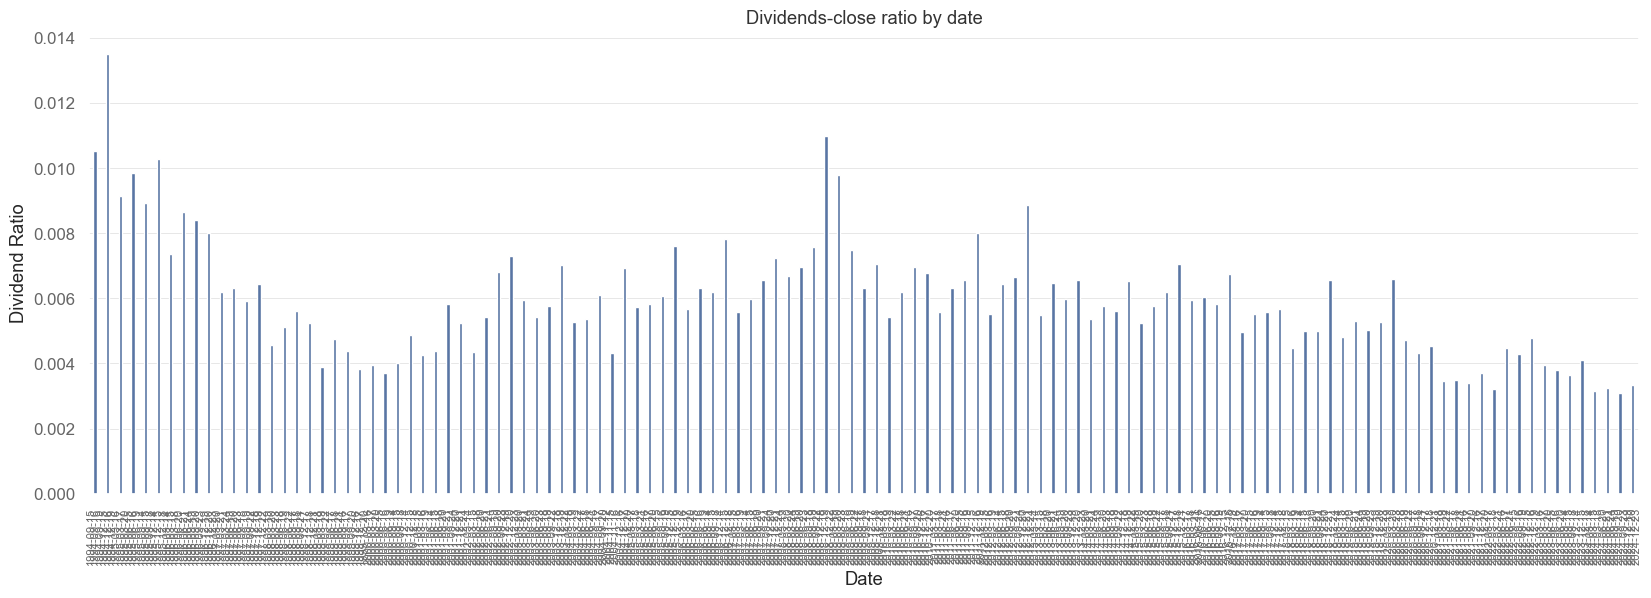

In [131]:

# Calculate the div_ratio
df_dividends['div_ratio'] = df_dividends['dividends'] / df_dividends['close']

# seaborn ile olustur daha kalin barlar
sns.barplot(data=df_dividends, x='date', y='div_ratio')
plt.title("Dividends-close ratio by date")
plt.xlabel("Date")
plt.ylabel("Dividend Ratio")
plt.xticks(rotation=90, fontsize=8)
plt.show()

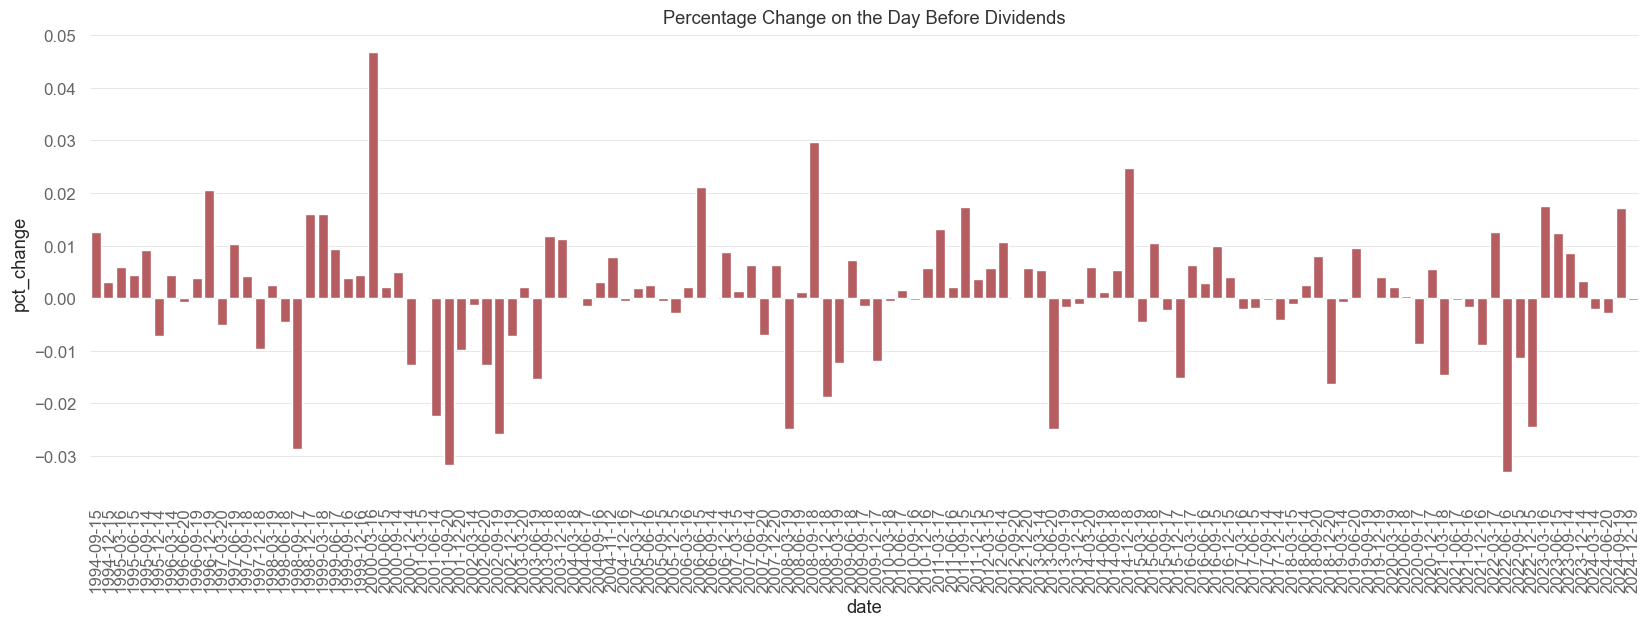

In [132]:

#sns ile olustur daha kalin barlar
sns.barplot(data=df.loc[np.sort(earlier_day)], x='date', y='pct_change', color='r')
plt.title("Percentage Change on the Day Before Dividends")
plt.xticks(rotation=90)
plt.show()

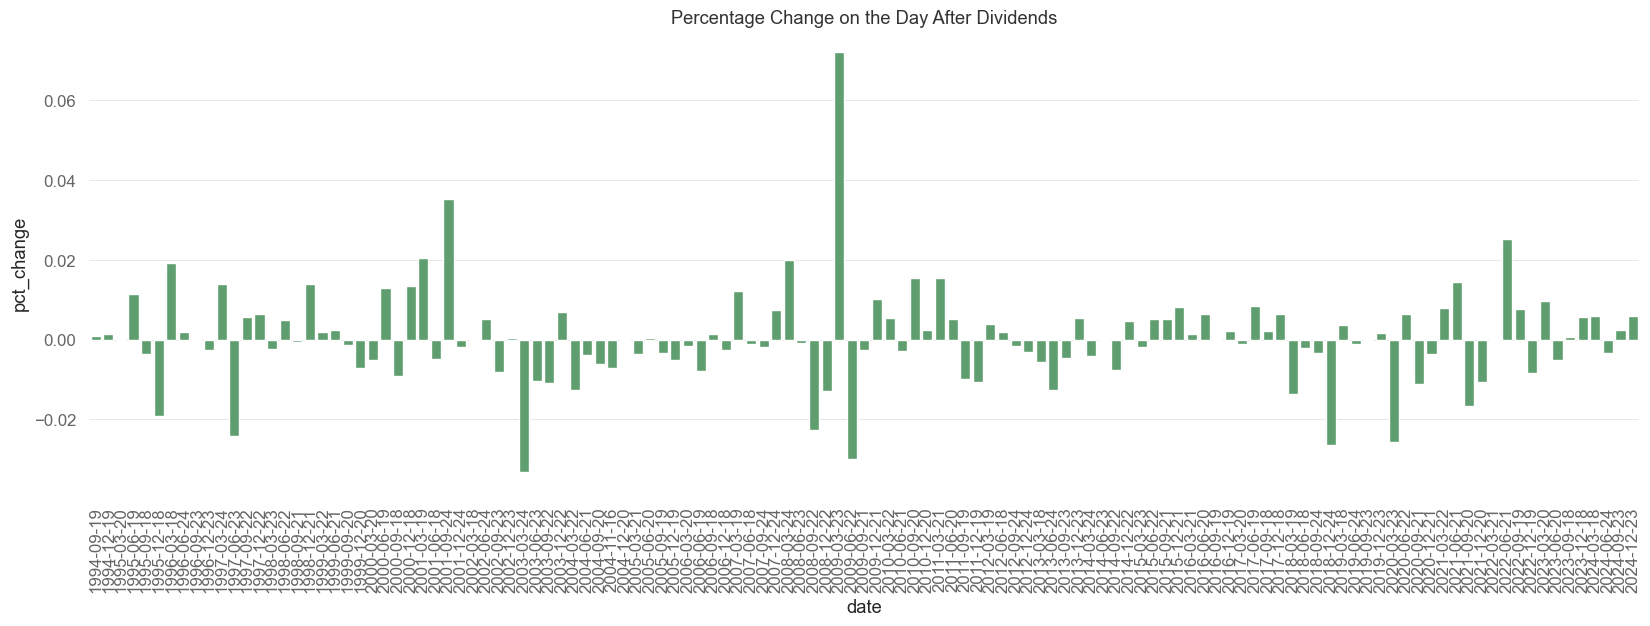

In [133]:

sns.barplot(data=df.loc[np.sort(next_day)], x='date', y='pct_change', color='g')
plt.title("Percentage Change on the Day After Dividends")
plt.xticks(rotation=90)
plt.show()


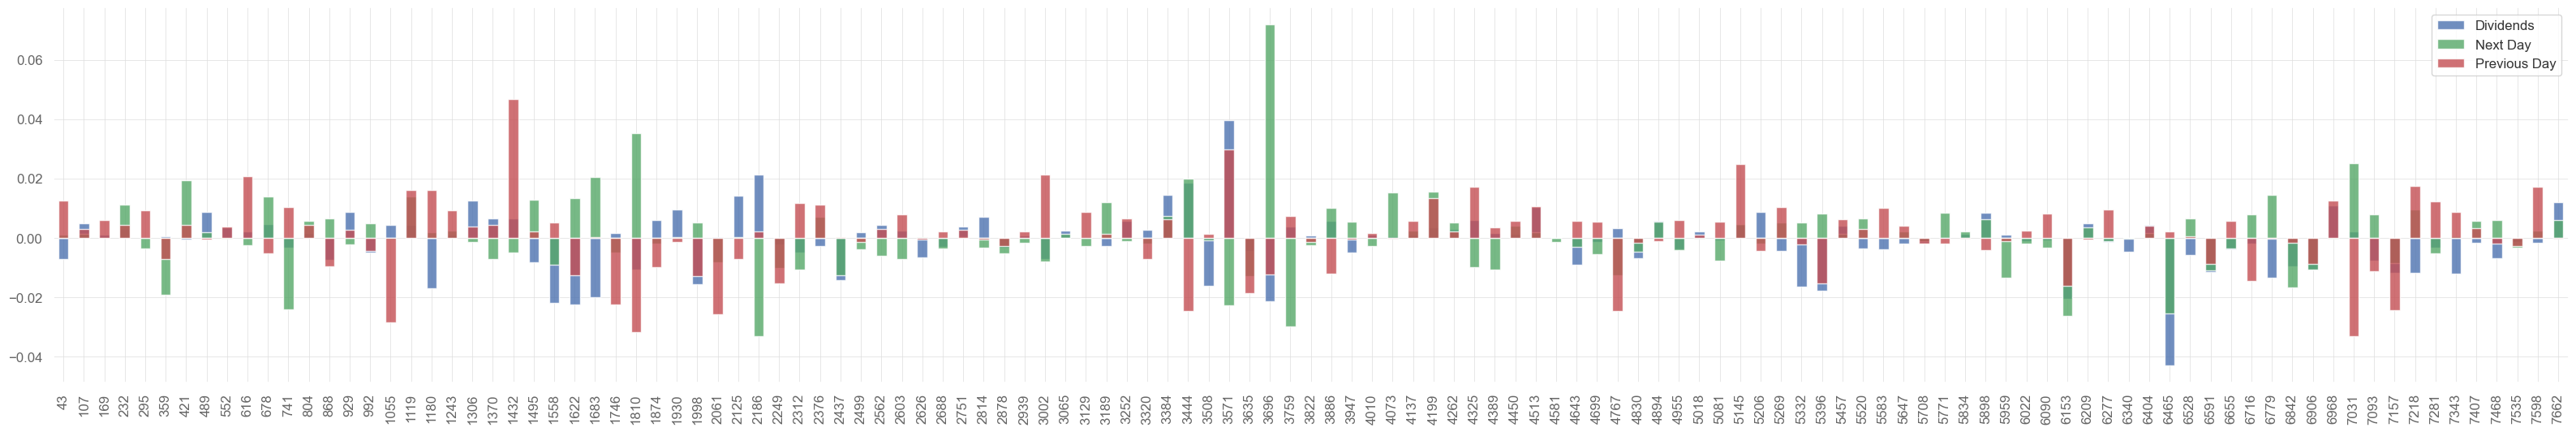

In [134]:
indexes = df[df['dividends'] > 0].index
plt.figure(figsize=(40, 6))
df.loc[np.sort(indexes), 'pct_change'].plot(kind='bar', color='b', alpha=0.8)
df.loc[np.sort(next_day), 'pct_change'].plot(kind='bar', color='g', alpha=0.8)
df.loc[np.sort(earlier_day), 'pct_change'].plot(kind='bar', color='r', alpha=0.8)
plt.legend(['Dividends', 'Next Day', 'Previous Day'])


In [135]:
df[df['dividends'] > 0]

,date,open,high,low,close,volume,dividends,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal
44,1994-09-16,27.394146,27.476110,27.303075,27.403254,571300,0.288,Friday,1994,9,16,3,-0.196415,-0.007117,-0.007447,0.000332,2.533497,-0.284058
108,1994-12-16,26.832279,26.933256,26.804740,26.878178,266100,0.363,Friday,1994,12,16,4,0.130632,0.004884,0.003168,0.001711,1.479168,0.060038
170,1995-03-17,29.201790,29.312543,29.183331,29.275625,89900,0.268,Friday,1995,3,17,1,0.029074,0.000994,-0.001530,0.002528,3.061222,0.046831
233,1995-06-16,31.907715,32.065536,31.907715,32.065536,325100,0.316,Friday,1995,6,16,2,0.094887,0.002968,-0.001969,0.004946,5.314022,0.041218
296,1995-09-15,34.887286,34.989951,34.765955,34.905952,431200,0.312,Friday,1995,9,15,3,-0.009651,-0.000276,-0.000811,0.000535,9.115219,-0.009651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,2023-12-15,463.543994,464.738691,461.510086,463.386017,141319300,1.906,Friday,2023,12,15,4,-0.764221,-0.001646,-0.001306,-0.000341,93.876434,-2.008026
7469,2024-03-15,505.313461,506.789182,503.243523,504.937103,107585800,1.595,Friday,2024,3,15,1,-3.491150,-0.006867,-0.006126,-0.000745,159.148224,1.939911
7536,2024-06-21,540.914767,542.156764,539.543597,541.024048,64513900,1.759,Friday,2024,6,21,2,-0.726318,-0.001341,-0.001542,0.000202,163.595459,-9.187500
7599,2024-09-20,565.935274,567.400314,563.274187,566.343872,77503100,1.746,Friday,2024,9,20,3,-0.980713,-0.001729,-0.002449,0.000722,166.455841,-1.390717


In [136]:
df['trend'] = df['pct_change'].apply(lambda x: 1 if x > 0 else -1)

In [137]:
# NumPy tabanlı çözüm
def conditional_cumsum_numpy(series):
    result = np.zeros_like(series)  # Sonuç için aynı boyutta bir array oluştur
    cumsum = 0  # Toplamı başlat
    for i, value in enumerate(series):
        if value == -1:  # -1 geldiğinde sıfırla
            cumsum = 0
        else:  # +1 olduğunda toplamaya devam et
            cumsum += value
        result[i] = cumsum
    return result

# Fonksiyonu uygulama
df['continuous_increased'] = conditional_cumsum_numpy(df['trend'])

df

,date,open,high,low,close,volume,dividends,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal,trend,continuous_increased
0,1994-07-15,26.269002,26.350470,26.259950,26.296158,49100,0.0,Friday,1994,7,15,3,0.009041,0.000344,-6.891310e-04,0.001034,1.281658,-0.252607,1,1
1,1994-07-18,26.296180,26.404804,26.296180,26.341440,72300,0.0,Monday,1994,7,18,3,0.045282,0.001722,8.426083e-07,0.001721,1.222277,-0.059381,1,2
2,1994-07-19,26.386689,26.395741,26.287117,26.287117,609500,0.0,Tuesday,1994,7,19,3,-0.054323,-0.002062,1.717796e-03,-0.003774,1.185410,-0.036867,-1,0
3,1994-07-20,26.305237,26.305237,26.106092,26.169456,185300,0.0,Wednesday,1994,7,20,3,-0.117661,-0.004476,6.893157e-04,-0.005162,1.067749,-0.117661,-1,0
4,1994-07-21,26.169448,26.241865,26.115136,26.223761,86300,0.0,Thursday,1994,7,21,3,0.054304,0.002075,-3.102310e-07,0.002075,1.296484,0.228735,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7680,2025-01-17,596.960022,599.359985,595.609985,597.580017,58070600,0.0,Friday,2025,1,17,1,5.940002,0.010040,8.991967e-03,0.001039,159.754547,7.929169,1,1
7681,2025-01-21,600.669983,603.059998,598.669983,603.049988,42532900,0.0,Tuesday,2025,1,21,1,5.469971,0.009154,5.170798e-03,0.003962,161.402893,1.648346,1,2
7682,2025-01-22,605.919983,607.820007,605.359985,606.440002,48196000,0.0,Wednesday,2025,1,22,1,3.390015,0.005621,4.759133e-03,0.000858,166.713501,5.310608,1,3
7683,2025-01-23,605.799988,609.750000,605.520020,609.750000,41152100,0.0,Thursday,2025,1,23,1,3.309998,0.005458,-1.055364e-03,0.006520,172.963226,6.249725,1,4


In [138]:
df.sort_values(by='continuous_increased', ascending=False).head(10)

,date,open,high,low,close,volume,dividends,week_day,year,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal,trend,continuous_increased
3946,2010-03-17,88.630137,89.176676,88.372047,88.888222,177468100,0.0,Wednesday,2010,3,17,1,0.523804,0.005928,0.003007,0.002912,6.574448,3.622108,1,14
3945,2010-03-16,87.908966,88.447911,87.666061,88.364418,168673000,0.0,Tuesday,2010,3,16,1,0.698349,0.007966,0.002771,0.005181,2.952339,0.646790,1,13
295,1995-09-14,34.720648,34.943454,34.627812,34.915604,457600,0.0,Thursday,1995,9,14,3,0.315659,0.009123,0.003489,0.005615,9.124870,-0.205910,1,12
3944,2010-03-15,87.491484,87.726797,86.990489,87.666069,146816800,0.0,Monday,2010,3,15,1,0.022781,0.000260,-0.001732,0.001995,2.305550,-3.369827,1,12
294,1995-09-13,34.404990,34.646363,34.395706,34.599945,239800,0.0,Wednesday,1995,9,13,3,0.157825,0.004582,-0.001078,0.005666,9.330780,0.553495,1,11
6408,2019-12-26,298.209580,299.414859,298.200328,299.405579,30911200,0.0,Thursday,2019,12,26,4,1.585388,0.005323,0.001307,0.004011,47.849915,1.810455,1,11
3943,2010-03-12,88.015235,88.030420,87.400383,87.643288,162074800,0.0,Friday,2010,3,12,1,0.007591,0.000087,0.004331,-0.004226,5.675377,6.976784,1,11
6407,2019-12-24,298.042691,298.089036,297.514224,297.820190,20270000,0.0,Tuesday,2019,12,24,4,0.009308,0.000031,0.000778,-0.000747,46.039459,-0.188766,1,10
3942,2010-03-11,87.066387,87.658474,86.800710,87.635696,160791100,0.0,Thursday,2010,3,11,1,0.364365,0.004175,-0.002348,0.006539,-1.301407,0.320282,1,10
293,1995-09-12,34.293582,34.442120,34.210030,34.442120,139500,0.0,Tuesday,1995,9,12,3,0.157810,0.004603,0.000270,0.004331,8.777285,0.085873,1,10


# In the past 20 years, there has been only one instance of 14 consecutive increases, and the same for 13 consecutive increases.

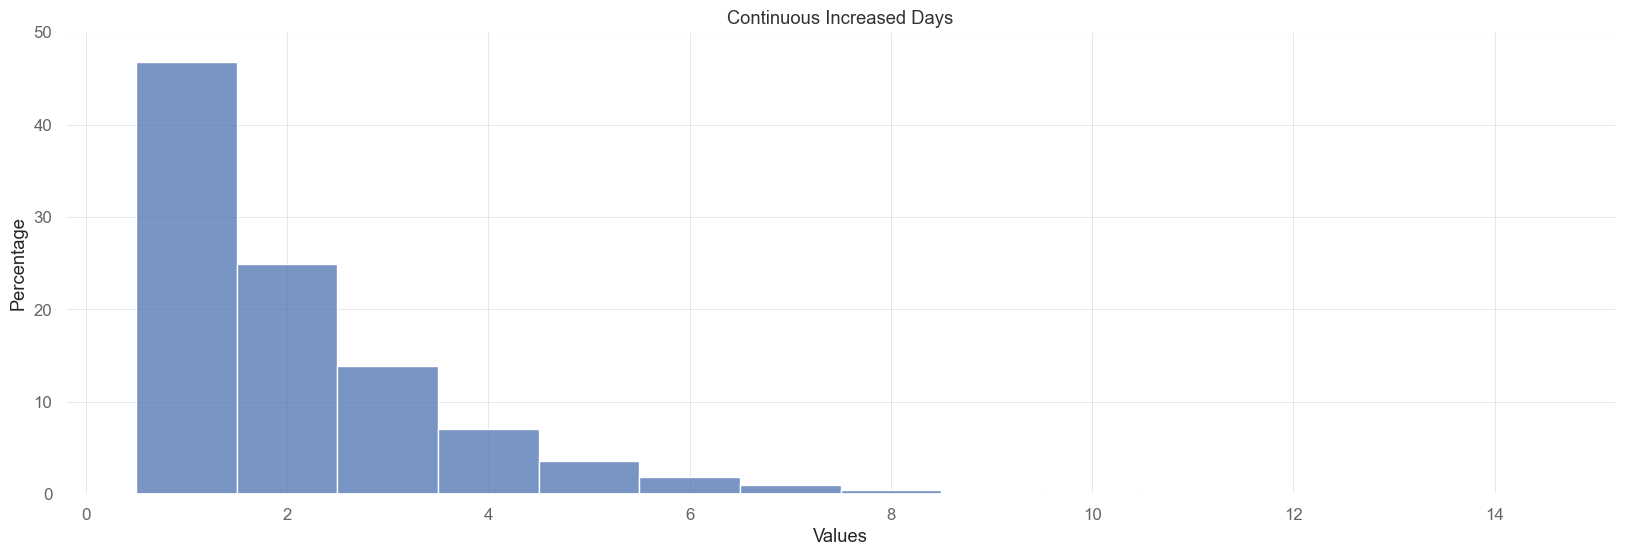

In [139]:
sns.histplot(data=df[df['continuous_increased']>0], x='continuous_increased', stat='percent', discrete=True)


plt.xlabel("Values")
plt.ylabel("Percentage")
plt.title("Continuous Increased Days")
plt.ylim(0, 50)
plt.show()

# 

# As you can see in the graph, approximately 45% of the increases last for a single day. Around 25% of the increases last for 2 days.

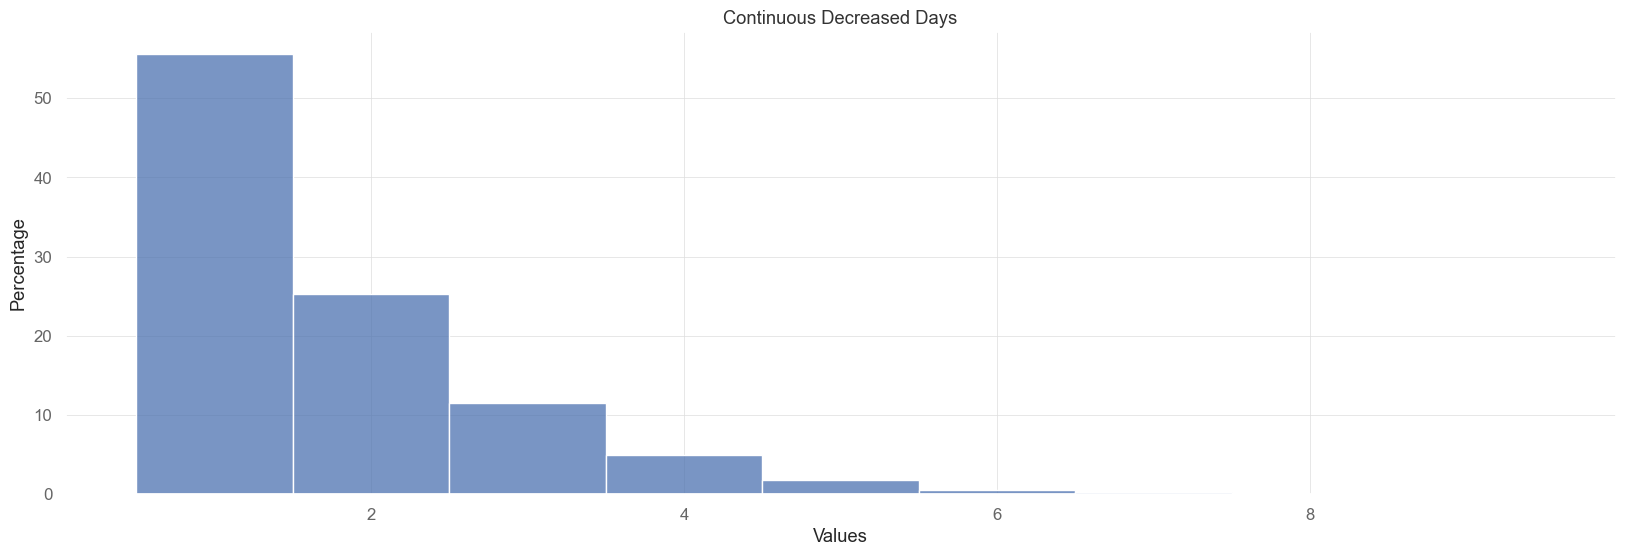

In [140]:
df['continuous_decreased'] = conditional_cumsum_numpy(df['trend']*-1)
sns.histplot(data=df[df['continuous_decreased']>0], x='continuous_decreased', stat='percent', discrete=True)


plt.xlabel("Values")
plt.ylabel("Percentage")
plt.title("Continuous Decreased Days")
plt.show()

In [141]:
df.sort_values(by='continuous_decreased', ascending=False).head(10)

,date,open,high,low,close,volume,dividends,week_day,year,month,...,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal,trend,continuous_increased,continuous_decreased
487,1996-06-18,40.352478,40.465669,40.041204,40.050636,718000,0.0,Tuesday,1996,6,...,2,-0.330139,-0.008176,-0.000701,-0.007480,12.970514,-0.357677,-1,0,9
3395,2008-01-08,102.932216,103.526273,100.295158,100.635658,326365700,0.0,Tuesday,2008,1,...,1,-1.651810,-0.016149,0.006303,-0.022311,11.309166,-1.771507,-1,0,8
486,1996-06-17,40.427938,40.578859,40.277017,40.380775,1101000,0.0,Monday,1996,6,...,2,-0.028282,-0.000700,0.000467,-0.001167,13.328192,-0.055813,-1,0,8
6155,2018-12-24,217.501218,219.139032,213.161031,213.224716,147311600,0.0,Monday,2018,12,...,4,-5.786926,-0.026423,-0.006897,-0.019662,-2.843948,-6.149368,-1,0,8
6451,2020-02-28,267.660803,276.181078,264.731087,274.669861,384975800,0.0,Friday,2020,2,...,1,-1.158875,-0.004201,-0.029612,0.026186,12.722046,-1.203888,-1,0,7
3587,2008-10-10,63.849290,69.133268,61.509032,65.129807,871026300,0.0,Friday,2008,10,...,4,-1.619049,-0.024256,-0.043440,0.020055,-41.665825,-2.240318,-1,0,7
3000,2006-06-13,86.766716,87.538037,85.932289,85.932289,185688800,0.0,Tuesday,2006,6,...,2,-1.009712,-0.011614,-0.002016,-0.009617,2.798340,-0.851891,-1,0,7
3394,2008-01-07,102.736634,103.040909,101.497802,102.287468,234991000,0.0,Monday,2008,1,...,1,-0.086914,-0.000849,0.003539,-0.004372,13.080673,-0.403893,-1,0,7
4375,2011-11-25,91.386017,92.422531,91.244674,91.354607,99557000,0.0,Friday,2011,11,...,4,-0.172760,-0.001888,-0.001544,-0.000344,5.880920,-0.309959,-1,0,7
485,1996-06-14,40.597709,40.597709,40.277002,40.409058,1468200,0.0,Friday,1996,6,...,2,-0.169785,-0.004184,0.000465,-0.004647,13.384005,-0.169785,-1,0,7


# In the past 20 years, there has been only one instance where there were 9 consecutive declines. There have been 3 instances with 8 consecutive declines. Approximately 55% of the time, a rise occurs after a single-day decline.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

# These consecutive statistics caught my interest; let's analyze them on a monthly basis.

/var/folders/wt/cfy8wn6d6w9c5s3tm7vmxskc0000gn/T/ipykernel_3831/103686625.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/wt/cfy8wn6d6w9c5s3tm7vmxskc0000gn/T/ipykernel_3831/103686625.py:4: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(
/var/folders/wt/cfy8wn6d6w9c5s3tm7vmxskc0000gn/T/ipykernel_3831/103686625.py:4: UserWarning: The palette list has more values (4173) than needed (12), which may not be intended.
  sns.barplot(


Text(0.5, 1.0, 'Continuous Increased Days by Month')

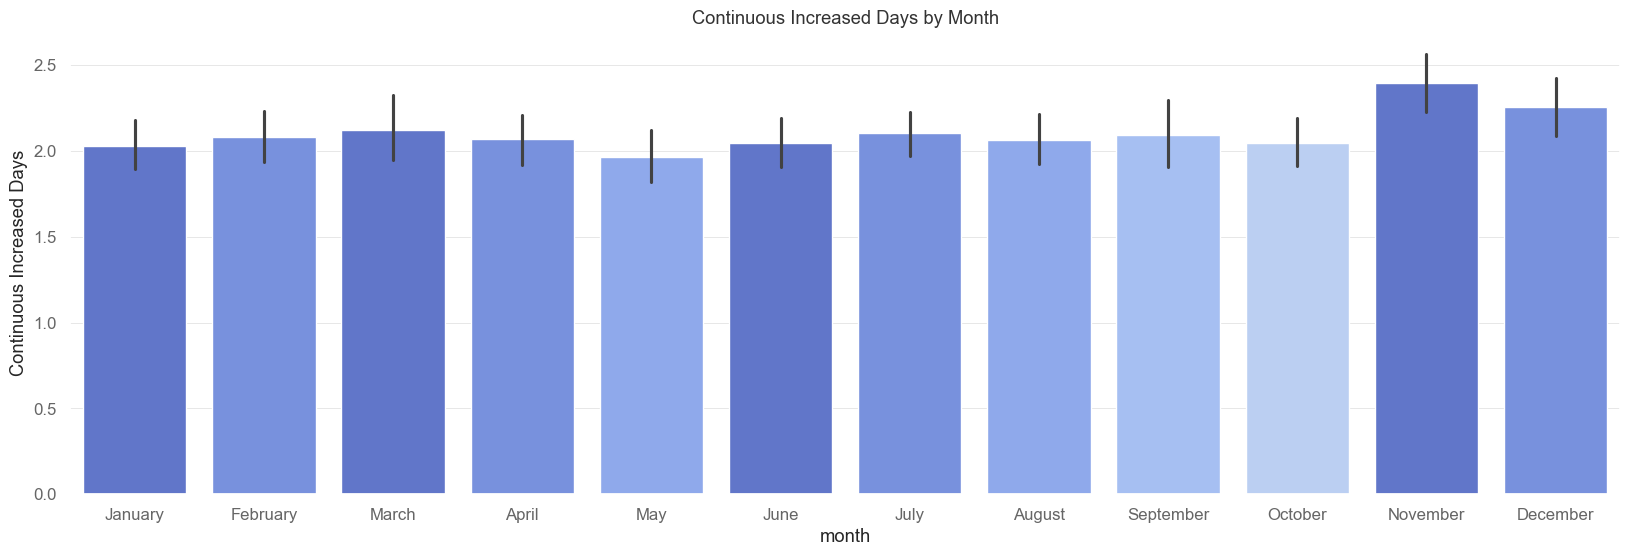

In [142]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
colors = df[df['continuous_increased']>0]['continuous_increased']

sns.barplot(
    data= df[df['continuous_increased']>0],
    x='month',
    y='continuous_increased',
    palette=cmap(colors / colors.max())
)
# name months x-axis
plt.xticks(ticks=range(0, 12), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
# name y-axis
plt.ylabel("Continuous Increased Days")
plt.title("Continuous Increased Days by Month")

/var/folders/wt/cfy8wn6d6w9c5s3tm7vmxskc0000gn/T/ipykernel_3831/140383654.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/wt/cfy8wn6d6w9c5s3tm7vmxskc0000gn/T/ipykernel_3831/140383654.py:4: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(
/var/folders/wt/cfy8wn6d6w9c5s3tm7vmxskc0000gn/T/ipykernel_3831/140383654.py:4: UserWarning: The palette list has more values (3512) than needed (12), which may not be intended.
  sns.barplot(


Text(0.5, 1.0, 'Continuous Decreased Days by Month')

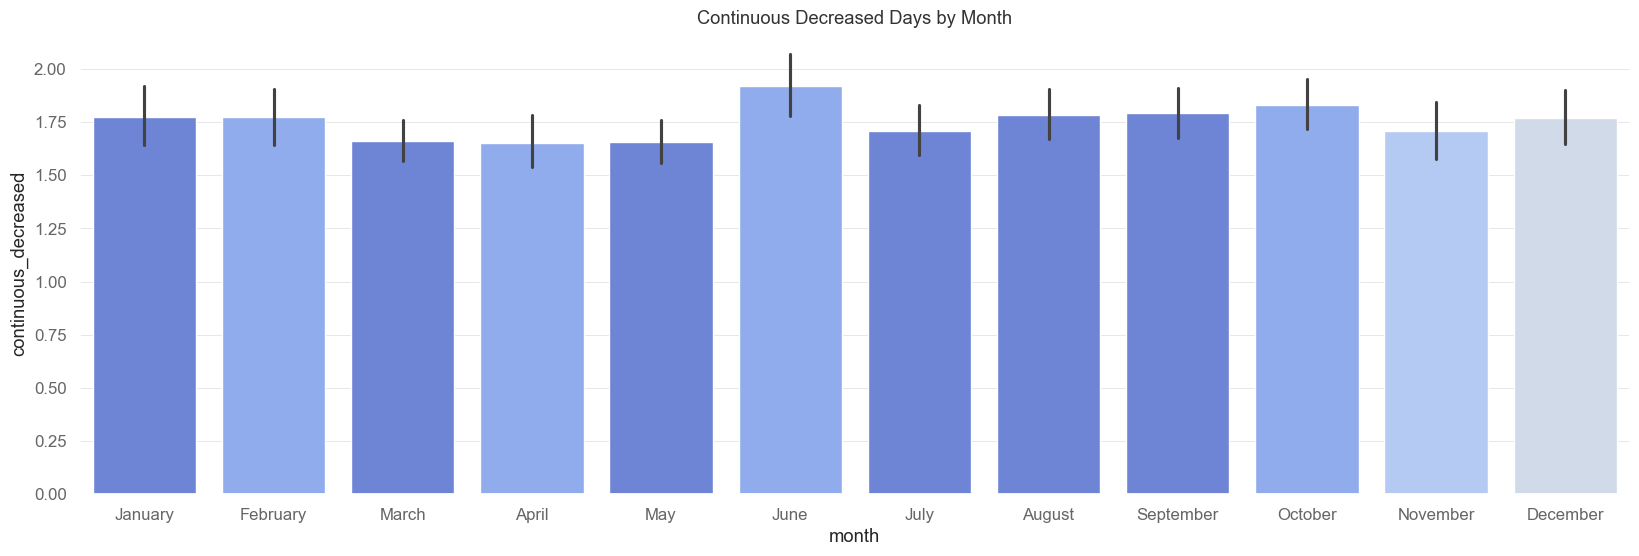

In [143]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
colors = df[df['continuous_decreased']>0]['continuous_decreased']

sns.barplot(
    data= df[df['continuous_decreased']>0],
    x='month',
    y='continuous_decreased',
    palette=cmap(colors / colors.max())
)
plt.xticks(ticks=range(0, 12), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
# name y-axis
plt.title("Continuous Decreased Days by Month")

# I want to see what is the distribution of percentage increase. We can identify outliers. I want to see the next how next day is effected after unusual changes.

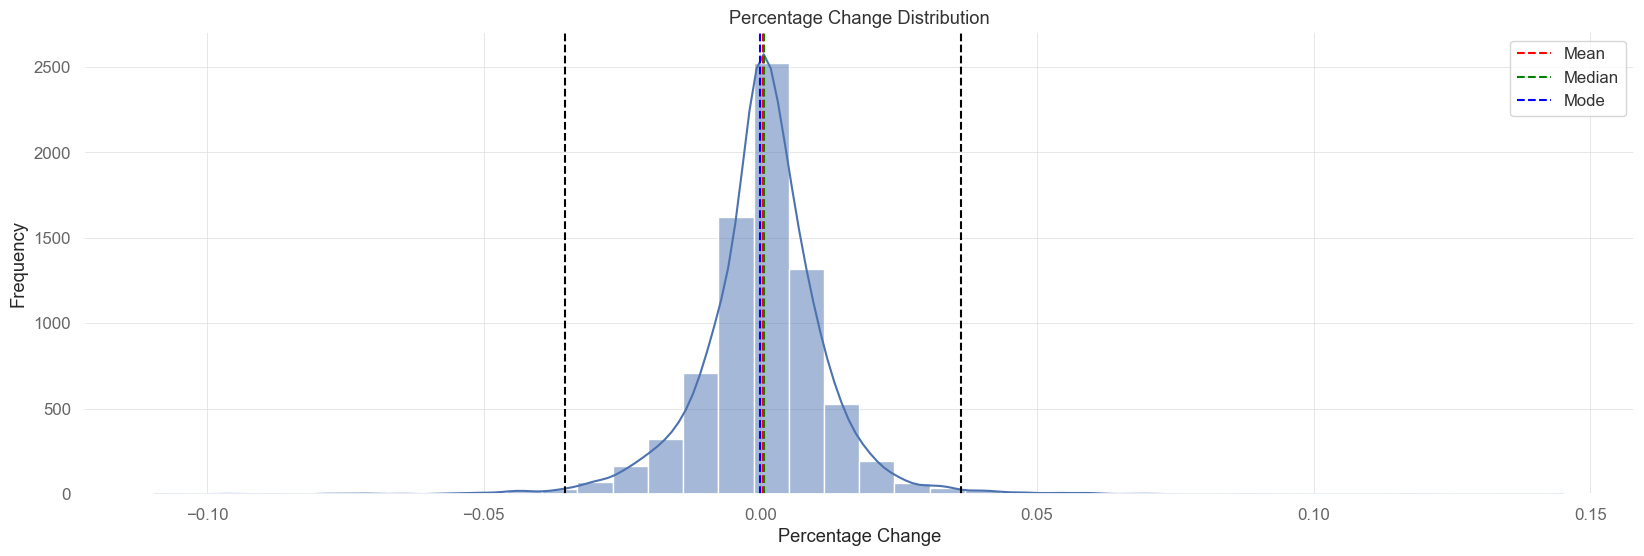

In [144]:
sns.histplot(data=df, x='pct_change', bins=40, kde=True)
# line for mean, median and mode
plt.axvline(df['pct_change'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df['pct_change'].median(), color='green', linestyle='--', label='Median')
plt.axvline(df['pct_change'].mode()[0], color='blue', linestyle='--', label='Mode')
plt.legend()
#line for outliers
plt.axvline(df['pct_change'].mean() + 3*df['pct_change'].std(), color='black', linestyle='--', label='Outliers')
plt.axvline(df['pct_change'].mean() - 3*df['pct_change'].std(), color='black', linestyle='--')
plt.title("Percentage Change Distribution")
plt.xlabel("Percentage Change")
plt.ylabel("Frequency")
plt.show()


In [145]:
df['pct_change'].describe()


count    7685.000000
mean        0.000480
std         0.011918
min        -0.109424
25%        -0.004523
50%         0.000712
75%         0.006124
max         0.145198
Name: pct_change, dtype: float64

In [146]:
# assing outlier values to a variables  
upper_bound = df['pct_change'].mean() + 3*df['pct_change'].std()
lower_bound = df['pct_change'].mean() - 3*df['pct_change'].std()

print(upper_bound, lower_bound)

0.03623352697587971 -0.03527375286650411


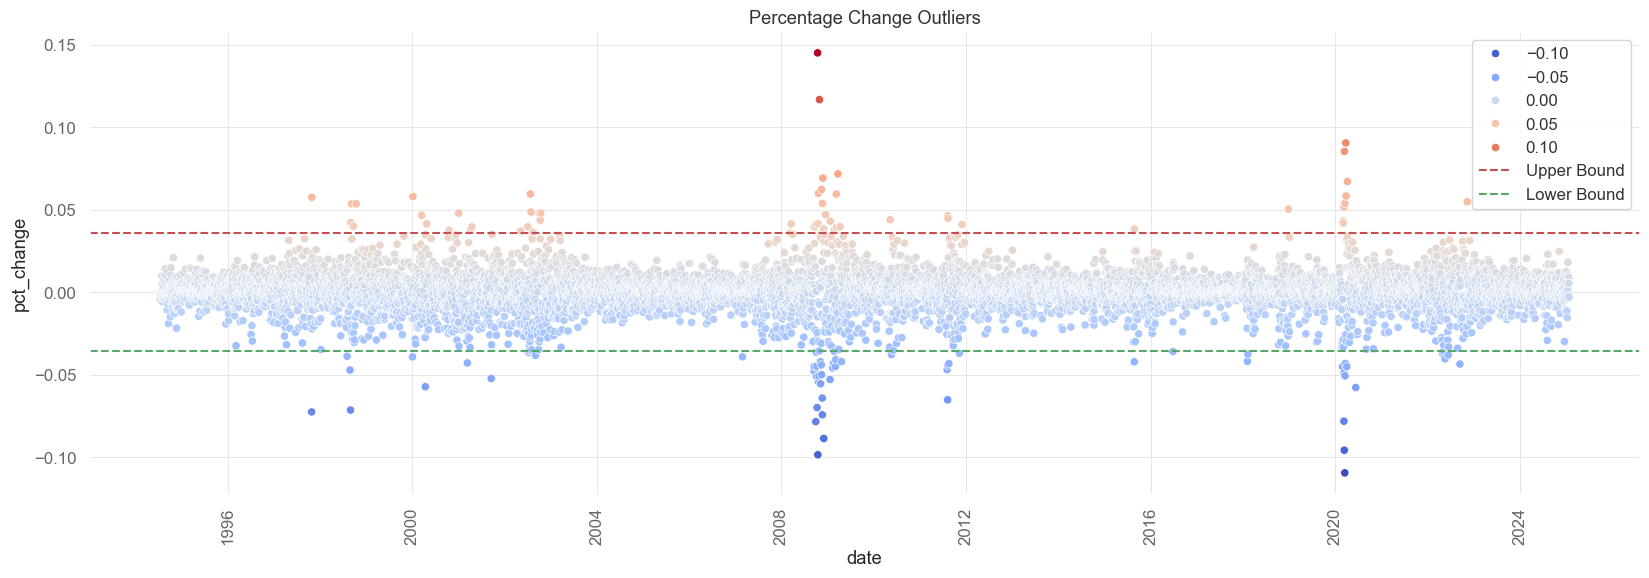

In [147]:
# create a scatter plot for pct_change
sns.scatterplot(data=df, x='date', y='pct_change', hue='pct_change', palette='coolwarm')
# draw a line for upper and lower bound
plt.axhline(upper_bound, color='r', linestyle='--', label='Upper Bound')
plt.axhline(lower_bound, color='g', linestyle='--', label='Lower Bound')
plt.legend()
plt.xticks(rotation=90)
plt.title("Percentage Change Outliers")
plt.show()

# looks like extreme increased days and extreme decreased days following each other

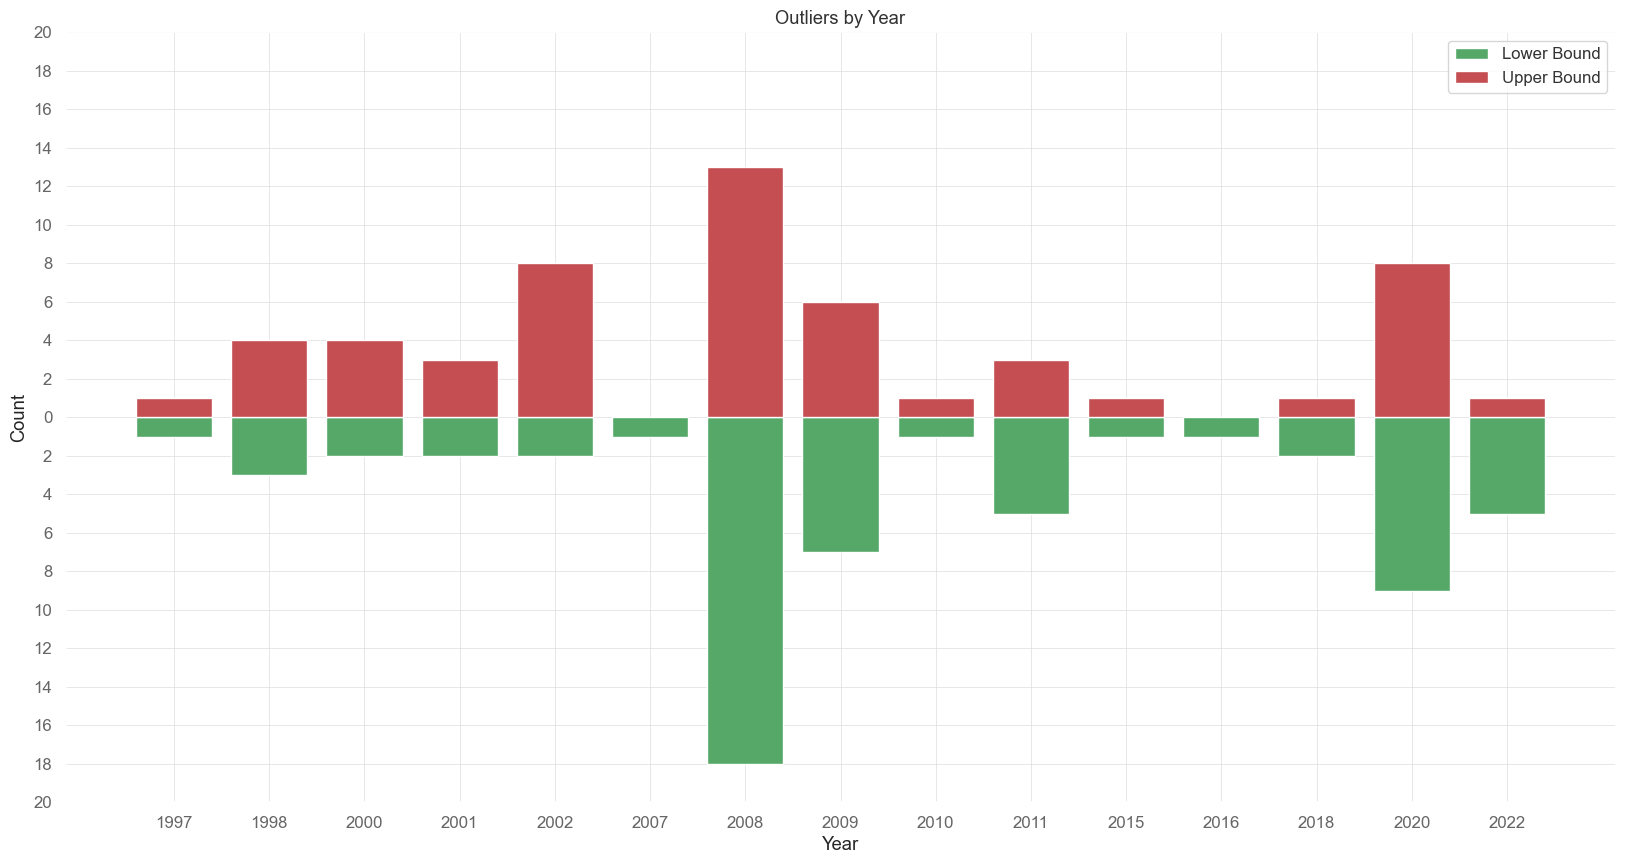

In [148]:
# filter the outliers
upper_index = df[df['pct_change'] >= upper_bound].index
lower_index = df[df['pct_change'] <= lower_bound].index

df_upper = df.loc[upper_index].groupby('year')['pct_change'].size().reset_index().rename(columns={'pct_change': 'count'})
df_lower = df.loc[lower_index].groupby('year')['pct_change'].size().reset_index().rename(columns={'pct_change': 'count'})
df_upper['year'] = df_upper['year'].astype(str)
df_lower['year'] = df_lower['year'].astype(str)
df_lower['count'] = df_lower['count'] * -1

plt.figure(figsize=(20, 10))
plt.bar(df_lower['year'], df_lower['count'], color='g', label='Lower Bound')
plt.bar(df_upper['year'], df_upper['count'], color='r', label='Upper Bound')

plt.yticks(ticks=range(-20, 20, 2))
plt.yticks(
    ticks=[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    labels=[20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.legend()
plt.title("Outliers by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


In [149]:
# indexes for upper outliers days and one day before and one day earlier
indexes = df[df['pct_change'] >= upper_bound].index 
earlier_day = indexes - 1
next_day = indexes + 1
indexes = np.concatenate([earlier_day, indexes, next_day])
indexes= np.sort(indexes)

df_outlier_days = df.loc[indexes]



In [150]:
df[df['pct_change']>upper_bound].shape[0]

54

pct_change
negative    32
positive    22
Name: count, dtype: int64


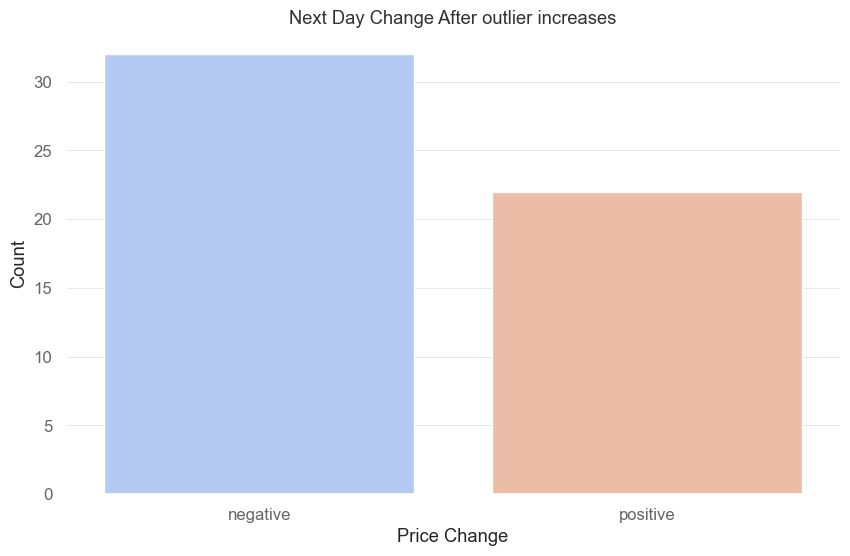

In [151]:
counts = df.loc[next_day]['pct_change'].apply(lambda x: 'positive' if x > 0 else 'negative').value_counts()

print(counts)

# visualize the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm', hue=counts.index)
plt.title("Next Day Change After outlier increases")
plt.xlabel("Price Change")
plt.ylabel("Count")
plt.show();



pct_change
negative    38
positive    16
Name: count, dtype: int64


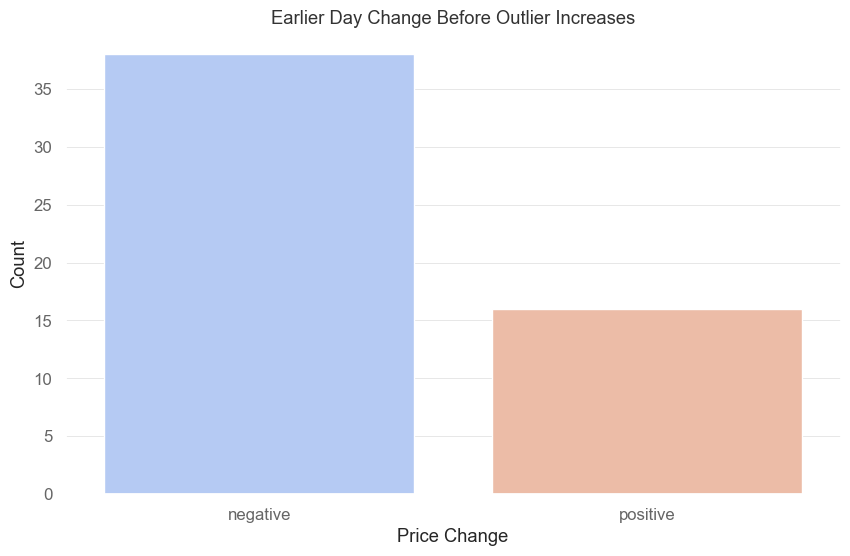

In [152]:
counts = df.loc[earlier_day]['pct_change'].apply(lambda x: 'positive' if x > 0 else 'negative').value_counts()
print(counts)
# visualize the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm', hue=counts.index)
plt.title("Earlier Day Change Before Outlier Increases")
plt.xlabel("Price Change")
plt.ylabel("Count")
plt.show();



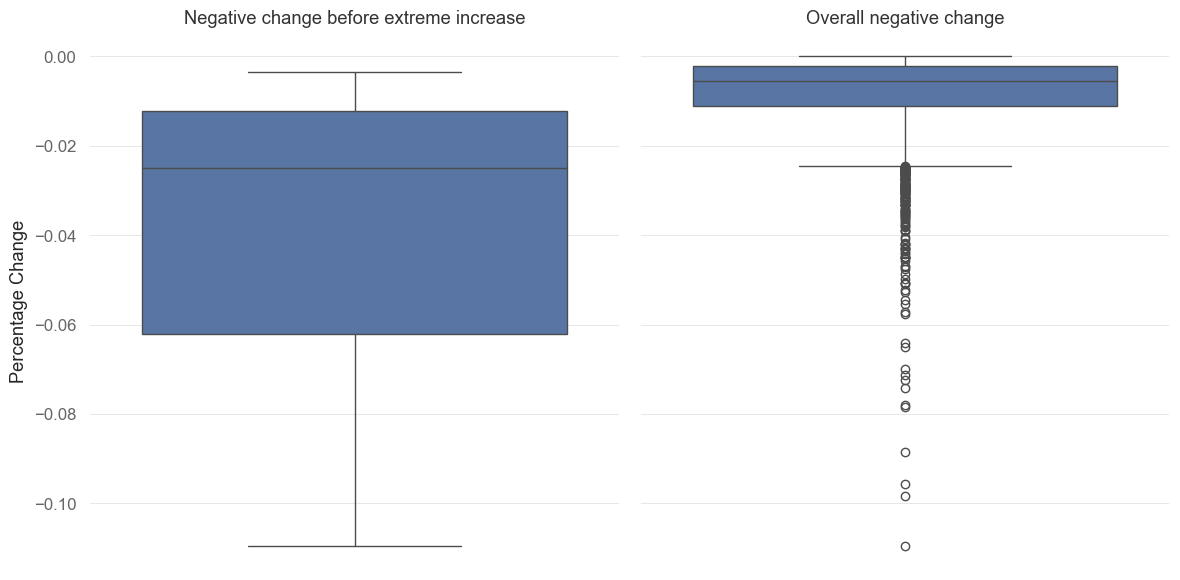

In [153]:
filtered_data = df.loc[earlier_day][df.loc[earlier_day]['pct_change'] < 0]

# Plot the boxplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First boxplot: Filtered data
sns.boxplot(data=filtered_data, y='pct_change', ax=axes[0])
axes[0].set_title("Negative change before extreme increase")
axes[0].set_ylabel("Percentage Change")

# Second boxplot: Full data
sns.boxplot(data=df[df['pct_change']<0], y='pct_change', ax=axes[1])
axes[1].set_title("Overall negative change")
axes[1].set_ylabel("")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

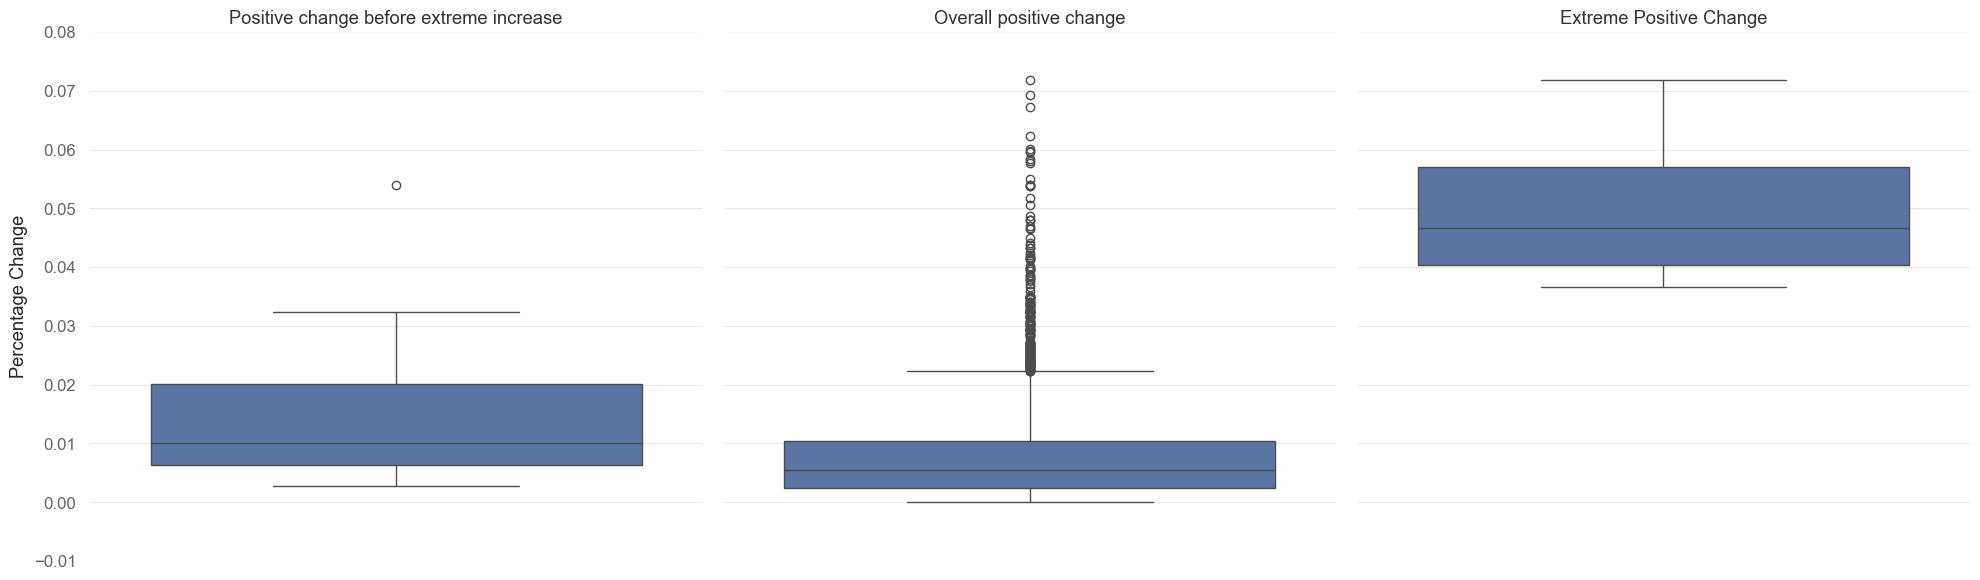

In [154]:
filtered_data = df.loc[earlier_day][df.loc[earlier_day]['pct_change'] > 0]

# Plot the boxplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# First boxplot: Filtered data
sns.boxplot(data=filtered_data, y='pct_change', ax=axes[0])
axes[0].set_title("Positive change before extreme increase")
axes[0].set_ylabel("Percentage Change")

# Second boxplot: Full data
sns.boxplot(data=df[df['pct_change'] > 0], y='pct_change', ax=axes[1])
axes[1].set_title("Overall positive change")
axes[1].set_ylabel("")

sns.boxplot(data= df[df['pct_change'] >= upper_bound], y='pct_change', ax=axes[2])
axes[2].set_title("Extreme Positive Change")
axes[2].set_ylabel("")

plt.ylim(-0.01 , 0.08)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [155]:
#indexes for lower outliers days and one day before and one day earlier
indexes = df[df['pct_change'] <= lower_bound].index 
earlier_day = indexes - 1
next_day = indexes + 1

df.iloc[indexes].count()[1]

60

In [156]:
indexes = np.concatenate([earlier_day, indexes, next_day])
indexes= np.sort(indexes)

df_outlier_days = df.loc[indexes]


pct_change
positive    38
negative    22
Name: count, dtype: int64


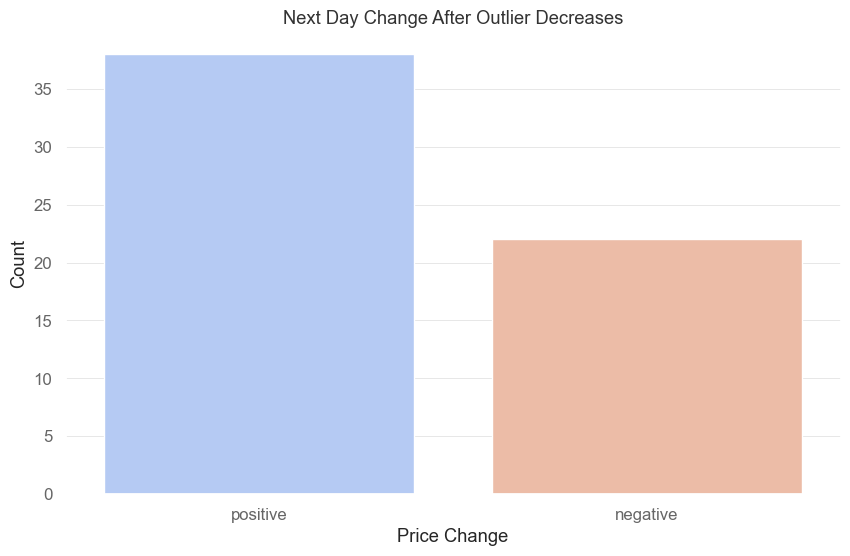

In [157]:
counts = df.loc[next_day]['pct_change'].apply(lambda x: 'positive' if x > 0 else 'negative').value_counts()

print(counts)

# visualize the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm', hue=counts.index)
plt.title("Next Day Change After Outlier Decreases")
plt.xlabel("Price Change")
plt.ylabel("Count")
plt.show();

pct_change
negative    33
positive    27
Name: count, dtype: int64


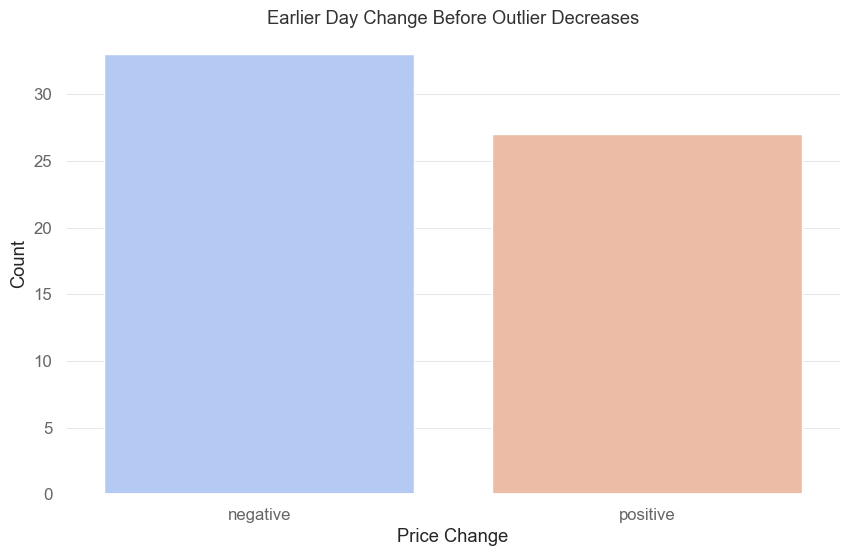

In [158]:
counts = df.loc[earlier_day]['pct_change'].apply(lambda x: 'positive' if x > 0 else 'negative').value_counts()
print(counts)
# visualize the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm', hue=counts.index)
plt.title("Earlier Day Change Before Outlier Decreases")
plt.xlabel("Price Change")
plt.ylabel("Count")
plt.show();


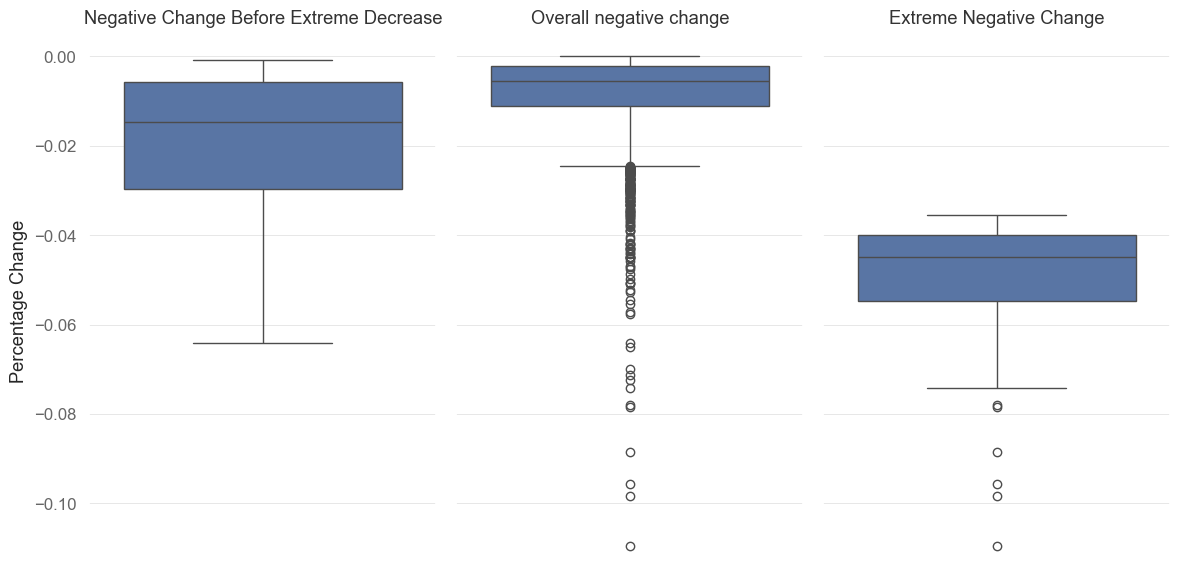

In [159]:
filtered_data = df.loc[earlier_day][df.loc[earlier_day]['pct_change'] < 0]

# Plot the boxplot
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

# First boxplot: Filtered data
sns.boxplot(data=filtered_data, y='pct_change', ax=axes[0])
axes[0].set_title("Negative Change Before Extreme Decrease")
axes[0].set_ylabel("Percentage Change")

# Second boxplot: Full data
sns.boxplot(data=df[df['pct_change']<0], y='pct_change', ax=axes[1])
axes[1].set_title("Overall negative change")
axes[1].set_ylabel("")

sns.boxplot(data= df[df['pct_change'] <= lower_bound], y='pct_change', ax=axes[2])
axes[2].set_title("Extreme Negative Change")
axes[2].set_ylabel("")
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

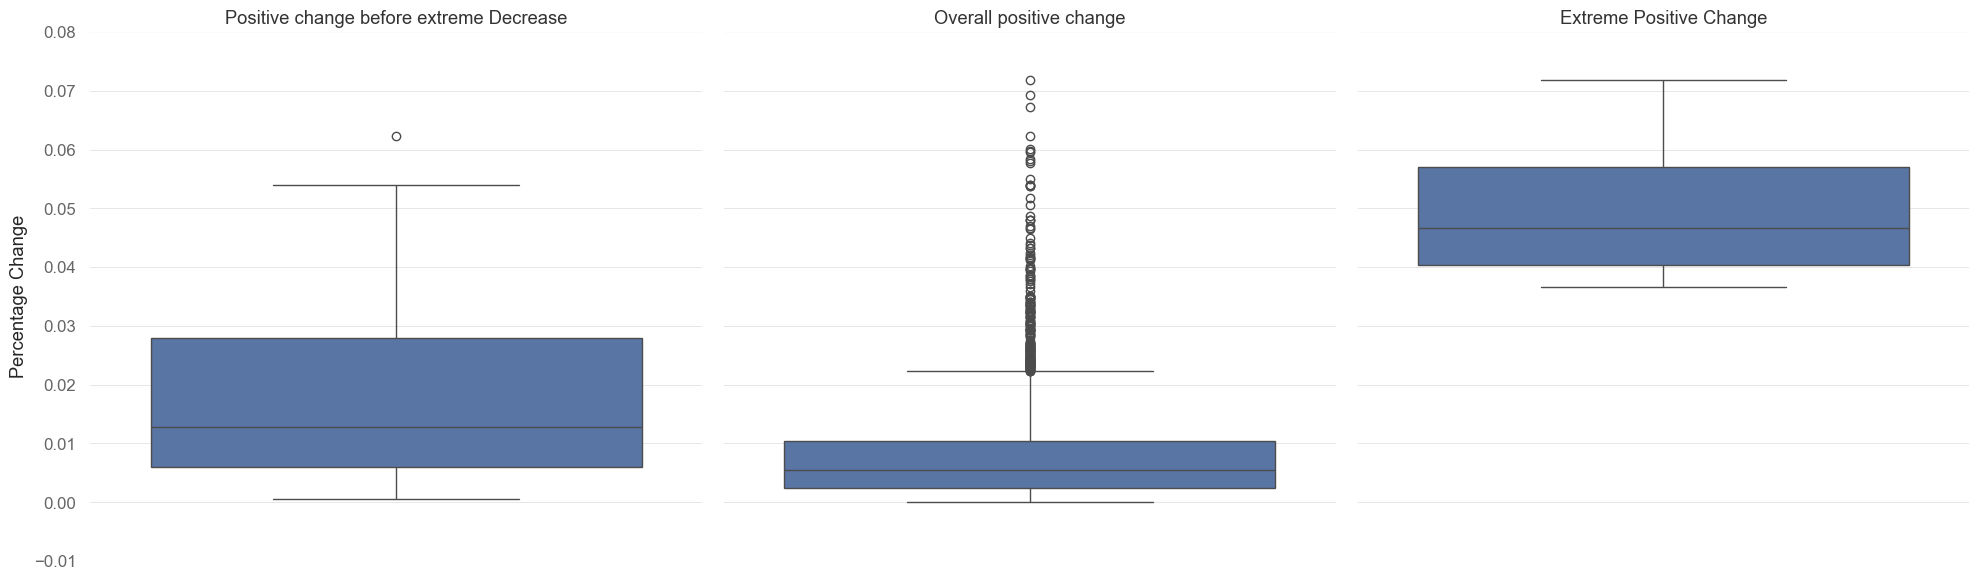

In [160]:
filtered_data = df.loc[earlier_day][df.loc[earlier_day]['pct_change'] > 0]

# Plot the boxplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# First boxplot: Filtered data
sns.boxplot(data=filtered_data, y='pct_change', ax=axes[0])
axes[0].set_title("Positive change before extreme Decrease")
axes[0].set_ylabel("Percentage Change")

# Second boxplot: Full data
sns.boxplot(data=df[df['pct_change'] > 0], y='pct_change', ax=axes[1])
axes[1].set_title("Overall positive change")
axes[1].set_ylabel("")

sns.boxplot(data= df[df['pct_change'] >= upper_bound], y='pct_change', ax=axes[2])
axes[2].set_title("Extreme Positive Change")
axes[2].set_ylabel("")

plt.ylim(-0.01 , 0.08)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [161]:
df.head()

,date,open,high,low,close,volume,dividends,week_day,year,month,...,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal,trend,continuous_increased,continuous_decreased
0,1994-07-15,26.269002,26.350470,26.259950,26.296158,49100,0.0,Friday,1994,7,...,3,0.009041,0.000344,-6.891310e-04,0.001034,1.281658,-0.252607,1,1,0
1,1994-07-18,26.296180,26.404804,26.296180,26.341440,72300,0.0,Monday,1994,7,...,3,0.045282,0.001722,8.426083e-07,0.001721,1.222277,-0.059381,1,2,0
2,1994-07-19,26.386689,26.395741,26.287117,26.287117,609500,0.0,Tuesday,1994,7,...,3,-0.054323,-0.002062,1.717796e-03,-0.003774,1.185410,-0.036867,-1,0,1
3,1994-07-20,26.305237,26.305237,26.106092,26.169456,185300,0.0,Wednesday,1994,7,...,3,-0.117661,-0.004476,6.893157e-04,-0.005162,1.067749,-0.117661,-1,0,2
4,1994-07-21,26.169448,26.241865,26.115136,26.223761,86300,0.0,Thursday,1994,7,...,3,0.054304,0.002075,-3.102310e-07,0.002075,1.296484,0.228735,1,1,0


In [162]:
# daily high-open ratio
df['high_open_ratio'] = (df['high'] - df['open'])/df['open']
df['high_close_ratio'] = (df['high'] - df['close'])/df['close'] 
df['low_open_ratio'] = (df['low'] - df['open'])/df['open']
df['low_close_ratio'] = (df['low'] - df['close'])/df['close']

df.head()


,date,open,high,low,close,volume,dividends,week_day,year,month,...,pct_close_open,seasonal_diff,second_diff_seasonal,trend,continuous_increased,continuous_decreased,high_open_ratio,high_close_ratio,low_open_ratio,low_close_ratio
0,1994-07-15,26.269002,26.350470,26.259950,26.296158,49100,0.0,Friday,1994,7,...,0.001034,1.281658,-0.252607,1,1,0,0.003101,0.002065,-0.000345,-1.376936e-03
1,1994-07-18,26.296180,26.404804,26.296180,26.341440,72300,0.0,Monday,1994,7,...,0.001721,1.222277,-0.059381,1,2,0,0.004131,0.002405,0.000000,-1.718213e-03
2,1994-07-19,26.386689,26.395741,26.287117,26.287117,609500,0.0,Tuesday,1994,7,...,-0.003774,1.185410,-0.036867,-1,0,1,0.000343,0.004132,-0.003774,-1.351504e-16
3,1994-07-20,26.305237,26.305237,26.106092,26.169456,185300,0.0,Wednesday,1994,7,...,-0.005162,1.067749,-0.117661,-1,0,2,0.000000,0.005189,-0.007571,-2.421308e-03
4,1994-07-21,26.169448,26.241865,26.115136,26.223761,86300,0.0,Thursday,1994,7,...,0.002075,1.296484,0.228735,1,1,0,0.002767,0.000690,-0.002075,-4.142216e-03


In [163]:
df = df[df.date >= '2020-01-01']
columns_to_drop = ['index', 'open', 'high', 'low', 'close', 'volume', 'year']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
df.head()

/var/folders/wt/cfy8wn6d6w9c5s3tm7vmxskc0000gn/T/ipykernel_3831/3525712026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


,date,dividends,week_day,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,seasonal_diff,second_diff_seasonal,trend,continuous_increased,continuous_decreased,high_open_ratio,high_close_ratio,low_open_ratio,low_close_ratio
6412,2020-01-02,0.0,Thursday,1,2,1,2.790588,0.009352,0.005220,0.004111,49.333084,3.078827,1,2,0,0.004173,0.000062,-0.003122,-0.007203
6413,2020-01-03,0.0,Friday,1,3,1,-2.280609,-0.007572,-0.011420,0.003892,46.584137,-2.748947,-1,0,1,0.007722,0.003815,-0.000187,-0.004063
6414,2020-01-06,0.0,Monday,1,6,1,1.140289,0.003815,-0.005955,0.009829,46.454636,-0.129501,1,1,0,0.010110,0.000278,-0.000406,-0.010135
6415,2020-01-07,0.0,Tuesday,1,7,1,-0.843567,-0.002811,-0.001915,-0.000898,43.449753,-3.004883,-1,0,1,0.001610,0.002510,-0.002415,-0.001518
6416,2020-01-08,0.0,Wednesday,1,8,1,1.594543,0.005329,0.000650,0.004676,45.647675,2.197922,1,1,0,0.008794,0.004099,-0.000836,-0.005486


In [164]:
df_news = pd.read_csv('news_sentiment.csv', index_col=0, parse_dates=True)
df_news.head()

,aapl,acn,adi,ame,amp,amzn,aph,avgo,brk-b,cost,...,ph,spgi,trow,tsla,tsm,txn,unh,v,wmt,xom
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.281213,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,-0.056483,0.0,0.0,0.222316,0.0,0.000000,0.000000
2020-01-02,0.182785,0.00000,0.0,0.000000,0.0,0.365399,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.317294,0.0,0.0,0.000000,0.0,0.436396,0.000000
2020-01-03,0.224765,0.00000,0.0,0.000000,0.0,0.206689,0.0,0.000000,0.234397,0.0,...,0.0,0.0,0.0,0.068317,0.0,0.0,0.000000,0.0,0.241386,0.000000
2020-01-06,-0.059535,0.00000,0.0,0.000000,0.0,0.077548,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.056199,0.0,0.0,0.000000,0.0,-0.410954,0.265997
2020-01-07,0.242719,0.34756,0.0,0.173936,0.0,0.272226,0.0,0.429233,0.199446,0.0,...,0.0,0.0,0.0,0.210498,0.0,0.0,0.157431,0.0,0.059462,0.198767


In [165]:
# merge the dataframes  
df = df.merge(df_news, how='left' , left_on='date', right_on='Date')

In [166]:
df.head()

,date,dividends,week_day,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,...,ph,spgi,trow,tsla,tsm,txn,unh,v,wmt,xom
0,2020-01-02,0.0,Thursday,1,2,1,2.790588,0.009352,0.005220,0.004111,...,0.0,0.0,0.0,0.317294,0.0,0.0,0.000000,0.0,0.436396,0.000000
1,2020-01-03,0.0,Friday,1,3,1,-2.280609,-0.007572,-0.011420,0.003892,...,0.0,0.0,0.0,0.068317,0.0,0.0,0.000000,0.0,0.241386,0.000000
2,2020-01-06,0.0,Monday,1,6,1,1.140289,0.003815,-0.005955,0.009829,...,0.0,0.0,0.0,0.056199,0.0,0.0,0.000000,0.0,-0.410954,0.265997
3,2020-01-07,0.0,Tuesday,1,7,1,-0.843567,-0.002811,-0.001915,-0.000898,...,0.0,0.0,0.0,0.210498,0.0,0.0,0.157431,0.0,0.059462,0.198767
4,2020-01-08,0.0,Wednesday,1,8,1,1.594543,0.005329,0.000650,0.004676,...,0.0,0.0,0.0,0.302827,0.0,0.0,0.134564,0.0,-0.071081,-0.075503


In [167]:
df.to_csv('preprocess_spy.csv')

,date,dividends,week_day,month,day,quarter,diff_close_close,pct_change,pct_open_close,pct_close_open,...,ph,spgi,trow,tsla,tsm,txn,unh,v,wmt,xom
0,2020-01-02,0.0,Thursday,1,2,1,2.790588,0.009352,0.005220,0.004111,...,0.0,0.0,0.0,0.317294,0.0,0.0,0.000000,0.0,0.436396,0.000000
1,2020-01-03,0.0,Friday,1,3,1,-2.280609,-0.007572,-0.011420,0.003892,...,0.0,0.0,0.0,0.068317,0.0,0.0,0.000000,0.0,0.241386,0.000000
2,2020-01-06,0.0,Monday,1,6,1,1.140289,0.003815,-0.005955,0.009829,...,0.0,0.0,0.0,0.056199,0.0,0.0,0.000000,0.0,-0.410954,0.265997
3,2020-01-07,0.0,Tuesday,1,7,1,-0.843567,-0.002811,-0.001915,-0.000898,...,0.0,0.0,0.0,0.210498,0.0,0.0,0.157431,0.0,0.059462,0.198767
4,2020-01-08,0.0,Wednesday,1,8,1,1.594543,0.005329,0.000650,0.004676,...,0.0,0.0,0.0,0.302827,0.0,0.0,0.134564,0.0,-0.071081,-0.075503
